<a href="https://colab.research.google.com/github/Hong071099/Project-Bike-Sale-Data/blob/main/Tuyet_Hong_Final_Project_Bike_Store_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Bike Store Sales Data


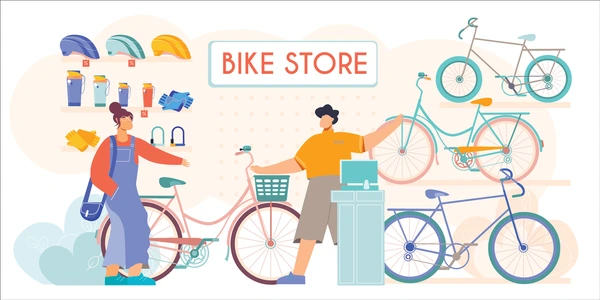

# Introduction

- This analysis focuses on evaluating the 2016 sales performance of the bike store, with the goal of expanding its product line and entering new markets. The study will explore key factors influencing sales, including product categories, customer demographics, and regional trends.
- Analyze customers behavior to retain old customers and acquire more new customers



# Overview Dataset

# I/ Prepration and Cleaning Data

## 1/ Import Relevant libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm

from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score, mean_absolute_error,mean_squared_error,r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
import statsmodels.api as sm

from IPython.display import Image
from google.colab import files

warnings.filterwarnings("ignore")

In [3]:
# Import the dataset
customer = pd.read_excel('https://drive.google.com/uc?export=download&id=1k7L7H8Z_IgyExgTZGuAZfcHR6o9ClPAq', sheet_name = "Customers")
calendar = pd.read_excel('https://drive.google.com/uc?export=download&id=1k7L7H8Z_IgyExgTZGuAZfcHR6o9ClPAq', sheet_name = "Calendar")
product = pd.read_excel('https://drive.google.com/uc?export=download&id=1k7L7H8Z_IgyExgTZGuAZfcHR6o9ClPAq', sheet_name = "Products")
sales = pd.read_excel('https://drive.google.com/uc?export=download&id=1k7L7H8Z_IgyExgTZGuAZfcHR6o9ClPAq', sheet_name ="Sales")
territory = pd.read_excel('https://drive.google.com/uc?export=download&id=1k7L7H8Z_IgyExgTZGuAZfcHR6o9ClPAq', sheet_name = "Territory")
budget = pd.read_excel('https://drive.google.com/uc?export=download&id=1k7L7H8Z_IgyExgTZGuAZfcHR6o9ClPAq', sheet_name ="Budget")



In [4]:
customer['Education'].unique()

array(['Bachelors', 'Partial College', 'High School',
       'Partial High School', 'Graduate Degree'], dtype=object)

In [5]:
#Change the value in the column Education
customer['Education'] = customer["Education"].replace({"Partial College": "Bachelors", "Partial High School": "High School"})

In [6]:
customer['Education'].unique()

array(['Bachelors', 'High School', 'Graduate Degree'], dtype=object)

In [7]:
# Combine the dataset

customer_sale = pd.merge(customer, sales, on='CustomerKey', how='right')
customer_sale_calendar = pd.merge(left = calendar, right = customer_sale, how = "right", left_on = "Date", right_on = "OrderDate")
customer_sale_calendar_product = pd.merge(customer_sale_calendar, product, on='ProductKey', how='right')
df = pd.merge(customer_sale_calendar_product, territory, on='SalesTerritoryKey', how='right')

df.head()

Date     DateKey    Year Quarter Month FiscalYear FiscalQuarter  \
0 2016-01-16  20160116.0  2016.0      Q1   Jan     FY2016           FQ3   
1 2016-01-31  20160131.0  2016.0      Q1   Jan     FY2016           FQ3   
2 2016-02-03  20160203.0  2016.0      Q1   Feb     FY2016           FQ3   
3 2016-02-07  20160207.0  2016.0      Q1   Feb     FY2016           FQ3   
4 2016-02-08  20160208.0  2016.0      Q1   Feb     FY2016           FQ3   

   FiscalMonthNum FiscalMonth MonthYear  ...            ProductName  \
0             7.0         Jan    Jan-16  ...  Sport-100 Helmet, Red   
1             7.0         Jan    Jan-16  ...  Sport-100 Helmet, Red   
2             8.0         Feb    Feb-16  ...  Sport-100 Helmet, Red   
3             8.0         Feb    Feb-16  ...  Sport-100 Helmet, Red   
4             8.0         Feb    Feb-16  ...  Sport-100 Helmet, Red   

   SubCategory   Category_y StandardCost Color ListPrice ProductLine  \
0      Helmets  Accessories      13.0863   Red     34.99       Sport   
1      Helmets  Accessories      13.0863   Red     34.99       Sport   
2      Helmets  Accessories      13.0863   Red     34.99       Sport   
3      Helmets  Accessories      13.0863   Red     34.99       Sport   
4      Helmets  Accessories      13.0863   Red     34.99       Sport   

      Region        Country     Continents  
0  Northwest  United States  North America  
1  Northwest  United States  North America  
2  Northwest  United States  North America  
3  Northwest  United States  North America  
4  Northwest  United States  North America  

[5 rows x 49 columns]

## 2/ Overview Data

In [8]:
# Check number of columns and rows of the Dataset

df.shape

(58189, 49)

In [9]:
# Check data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58189 entries, 0 to 58188
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58189 non-null  datetime64[ns]
 1   DateKey            58189 non-null  float64       
 2   Year               58189 non-null  float64       
 3   Quarter            58189 non-null  object        
 4   Month              58189 non-null  object        
 5   FiscalYear         58189 non-null  object        
 6   FiscalQuarter      58189 non-null  object        
 7   FiscalMonthNum     58189 non-null  float64       
 8   FiscalMonth        58189 non-null  object        
 9   MonthYear          58189 non-null  object        
 10  Weekday            58189 non-null  object        
 11  CustomerKey        58189 non-null  float64       
 12  FirstName          58189 non-null  object        
 13  LastName           58189 non-null  object        
 14  BirthD

## 3/ Cleaning Data

### 3.1/ Handling unwanted data

In [10]:
# Drop data and rename columns
df.drop(columns = ["DateKey","FiscalYear", "FiscalQuarter", "FiscalMonthNum", "FiscalMonth",
                   "Month", "MonthYear","Color","OrderDate" , "Order_year", "Sub-category",
                   "Tax_pct", "ListPrice", "UnitPrice", "Category_y", "Quarter", "Weekday"],
                    inplace = True)
df.rename(columns = {"Category_x": "Category", "Price": "UnitPrice" }, inplace= True)
df.head()

Date    Year  CustomerKey FirstName  LastName  BirthDate  \
0 2016-01-16  2016.0      16218.0     Julia   Simmons 1953-10-04   
1 2016-01-31  2016.0      11224.0   Tiffany        Li 1951-09-06   
2 2016-02-03  2016.0      22282.0  Jonathan    Hughes 1964-01-27   
3 2016-02-07  2016.0      15257.0   Matthew  Anderson 1978-03-25   
4 2016-02-08  2016.0      29014.0      Ryan    Powell 1950-02-04   

  MaritalStatus Gender  YearlyIncome  TotalChildren  ... TotalSaleAmount  \
0             M      F       30000.0            1.0  ...           34.99   
1             S      F       70000.0            2.0  ...           34.99   
2             S      M       40000.0            0.0  ...           69.98   
3             S      M       40000.0            0.0  ...           34.99   
4             M      M       60000.0            2.0  ...           34.99   

  UnitPrice  TaxAmt            ProductName  SubCategory  StandardCost  \
0     34.99  2.7992  Sport-100 Helmet, Red      Helmets       13.0863   
1     34.99  2.7992  Sport-100 Helmet, Red      Helmets       13.0863   
2     34.99  2.7992  Sport-100 Helmet, Red      Helmets       13.0863   
3     34.99  2.7992  Sport-100 Helmet, Red      Helmets       13.0863   
4     34.99  2.7992  Sport-100 Helmet, Red      Helmets       13.0863   

  ProductLine     Region        Country     Continents  
0       Sport  Northwest  United States  North America  
1       Sport  Northwest  United States  North America  
2       Sport  Northwest  United States  North America  
3       Sport  Northwest  United States  North America  
4       Sport  Northwest  United States  North America  

[5 rows x 32 columns]

### 3.2/ Handling duplicated and missing values

In [11]:
# Check duplicated
df.duplicated().sum()

np.int64(7)

In [12]:
# Drop duplicated values
df.drop_duplicates(inplace=True)

In [13]:
#Check missing values
df.isna().sum()

Date                 0
Year                 0
CustomerKey          0
FirstName            0
LastName             0
BirthDate            0
MaritalStatus        0
Gender               0
YearlyIncome         0
TotalChildren        0
Education            0
Occupation           0
HouseOwnerFlag       0
NumberCarsOwned      0
CarOwnerFlag         0
ProductKey           0
Category             0
Order_month          0
SalesTerritoryKey    0
OrderQuantity        0
ProductCost          0
TotalCostAmount      0
TotalSaleAmount      0
UnitPrice            0
TaxAmt               0
ProductName          0
SubCategory          0
StandardCost         0
ProductLine          0
Region               0
Country              0
Continents           0
dtype: int64

### 3.3/ Change Datatype

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  float64       
 2   CustomerKey        58182 non-null  float64       
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  float64       
 9   TotalChildren      58182 non-null  float64       
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  float64       
 13  NumberCarsOwned    58182 non-null  float64       
 14  CarOwnerFla

In [15]:
# Change datetime datatype
df["BirthDate"] = pd.to_datetime(df["BirthDate"])
df['Year'] = df['Year'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  int64         
 2   CustomerKey        58182 non-null  float64       
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  float64       
 9   TotalChildren      58182 non-null  float64       
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  float64       
 13  NumberCarsOwned    58182 non-null  float64       
 14  CarOwnerFla

In [16]:
# Change int datatype
df['CustomerKey'] = df['CustomerKey'].astype(object)
df['TotalChildren'] = df['TotalChildren'].astype(int)
df['HouseOwnerFlag'] = df['HouseOwnerFlag'].astype(int)
df['NumberCarsOwned'] = df['NumberCarsOwned'].astype(int)
df['OrderQuantity'] = df['OrderQuantity'].astype(int)
df['YearlyIncome'] = df['YearlyIncome'].astype(int)
df['SalesTerritoryKey'] = df['SalesTerritoryKey'].astype(int)
df['TotalSaleAmount'] = df['TotalSaleAmount'].astype(int)
df['TotalCostAmount'] = df['TotalCostAmount'].astype(int)
df['TaxAmt'] = df['TaxAmt'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  int64         
 2   CustomerKey        58182 non-null  object        
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  int64         
 9   TotalChildren      58182 non-null  int64         
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  int64         
 13  NumberCarsOwned    58182 non-null  int64         
 14  CarOwnerFla

### 3.4/ Add new features

In [17]:
#Customer dataset add group of age column
df["Age"] = 2016 - df["BirthDate"].dt.year
df['AgeGroup'] =  pd.cut(df["Age"], bins=[20, 30, 50, 60, 120], labels = ['Young','Adult',"Senior",'Elder'])

# Sale dataset add profit column
df["Profit"] = df["TotalSaleAmount"] - df["TotalCostAmount"] - df["TaxAmt"]

In [18]:
df.head()

Date  Year CustomerKey FirstName  LastName  BirthDate MaritalStatus  \
0 2016-01-16  2016     16218.0     Julia   Simmons 1953-10-04             M   
1 2016-01-31  2016     11224.0   Tiffany        Li 1951-09-06             S   
2 2016-02-03  2016     22282.0  Jonathan    Hughes 1964-01-27             S   
3 2016-02-07  2016     15257.0   Matthew  Anderson 1978-03-25             S   
4 2016-02-08  2016     29014.0      Ryan    Powell 1950-02-04             M   

  Gender  YearlyIncome  TotalChildren  ...            ProductName SubCategory  \
0      F         30000              1  ...  Sport-100 Helmet, Red     Helmets   
1      F         70000              2  ...  Sport-100 Helmet, Red     Helmets   
2      M         40000              0  ...  Sport-100 Helmet, Red     Helmets   
3      M         40000              0  ...  Sport-100 Helmet, Red     Helmets   
4      M         60000              2  ...  Sport-100 Helmet, Red     Helmets   

   StandardCost  ProductLine     Region        Country     Continents Age  \
0       13.0863        Sport  Northwest  United States  North America  63   
1       13.0863        Sport  Northwest  United States  North America  65   
2       13.0863        Sport  Northwest  United States  North America  52   
3       13.0863        Sport  Northwest  United States  North America  38   
4       13.0863        Sport  Northwest  United States  North America  66   

   AgeGroup   Profit  
0     Elder  18.2008  
1     Elder  18.2008  
2    Senior  40.2008  
3     Adult  18.2008  
4     Elder  18.2008  

[5 rows x 35 columns]

In [19]:
# Extract time-related features
df["Month"] = df["Date"].dt.month

# Drop irrelevant columns
df_drop = df.drop(columns=["Date", "CustomerKey", "FirstName", "LastName", "BirthDate"])


# II/ Descriptive Analysis

## 1/ Sale Analysis

### 1.1/ Overview

In [20]:
df.describe()

Date          Year  \
count                          58182  58182.000000   
mean   2016-06-03 03:52:47.866350336   2015.868791   
min              2014-01-01 00:00:00   2014.000000   
25%              2016-04-01 00:00:00   2016.000000   
50%              2016-07-07 00:00:00   2016.000000   
75%              2016-10-10 00:00:00   2016.000000   
max              2016-12-30 00:00:00   2016.000000   
std                              NaN      0.435692   

                           BirthDate   YearlyIncome  TotalChildren  \
count                          58182   58182.000000   58182.000000   
mean   1962-03-02 21:32:20.517685856   59765.219484       1.838816   
min              1910-08-13 00:00:00   10000.000000       0.000000   
25%              1954-12-20 00:00:00   30000.000000       0.000000   
50%              1963-09-19 00:00:00   60000.000000       2.000000   
75%              1970-07-08 00:00:00   80000.000000       3.000000   
max              1980-12-26 00:00:00  170000.000000       5.000000   
std                              NaN   33125.358429       1.614453   

       HouseOwnerFlag  NumberCarsOwned  CarOwnerFlag    ProductKey  \
count    58182.000000     58182.000000  58182.000000  58182.000000   
mean         0.690557         1.502389      1.266388    437.203035   
min          0.000000         0.000000      0.000000    214.000000   
25%          0.000000         1.000000      1.000000    358.000000   
50%          1.000000         2.000000      2.000000    479.000000   
75%          1.000000         2.000000      2.000000    529.000000   
max          1.000000         4.000000      2.000000    606.000000   
std          0.462268         1.155433      0.816296    118.099974   

       SalesTerritoryKey  OrderQuantity   ProductCost  TotalCostAmount  \
count       58182.000000   58182.000000  58182.000000     58182.000000   
mean            6.261627       1.569437    296.574103       464.782544   
min             1.000000       1.000000      0.856500         0.000000   
25%             4.000000       1.000000      3.362300         3.000000   
50%             7.000000       1.000000     12.192400        13.000000   
75%             9.000000       2.000000    343.649600       343.000000   
max            10.000000       4.000000   2171.294200      8685.000000   
std             2.960374       1.047578    560.196084      1099.357945   

       TotalSaleAmount     UnitPrice        TaxAmt  StandardCost  \
count     58182.000000  58182.000000  58182.000000  58182.000000   
mean        789.443780    503.724837     40.297988    296.574103   
min           2.000000      2.290000      0.183200      0.856500   
25%           9.000000      8.990000      0.719200      3.362300   
50%          34.000000     32.600000      2.608000     12.192400   
75%         539.000000    539.990000     43.199200    343.649600   
max       14313.000000   3578.270000    286.261600   2171.294200   
std        1849.218764    941.504295     75.320345    560.196084   

                Age        Profit         Month  
count  58182.000000  58182.000000  58182.000000  
mean      54.325461    284.363248      7.159379  
min       36.000000      1.280800      1.000000  
25%       46.000000      4.680800      4.000000  
50%       53.000000     18.200800      7.000000  
75%       62.000000    152.800800     10.000000  
max      106.000000   5679.000800     12.000000  
std       11.004288    697.018415      3.284306

In [21]:
#Bike Store Sale Overview

In [22]:
from IPython.display import HTML

# Tableau Public link
tableau_url = "https://public.tableau.com/views/Book1_17425364309350/Story1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link"
# Display a clickable link
HTML(f'<a href="{tableau_url}" target="_blank">Click here to view Tableau Chart</a>')


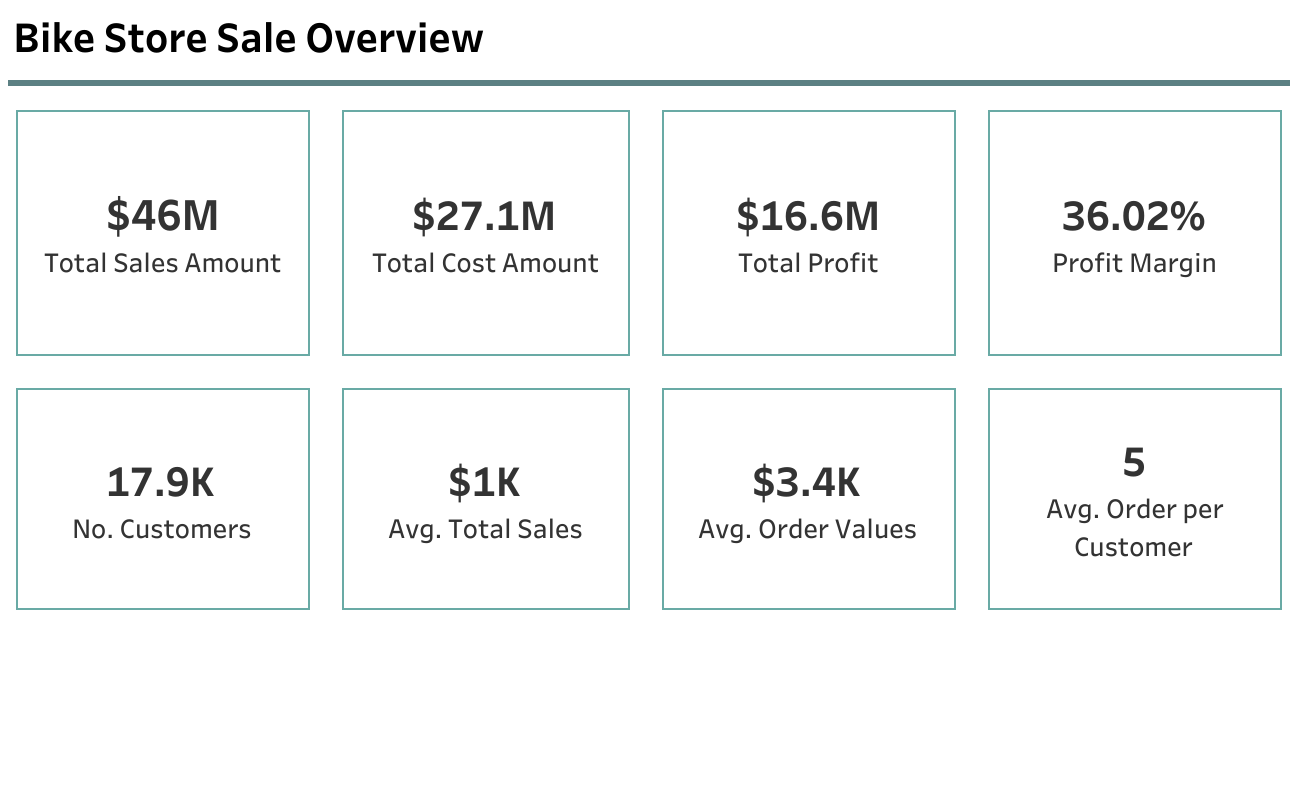

In [23]:
# Sales Trend Over year

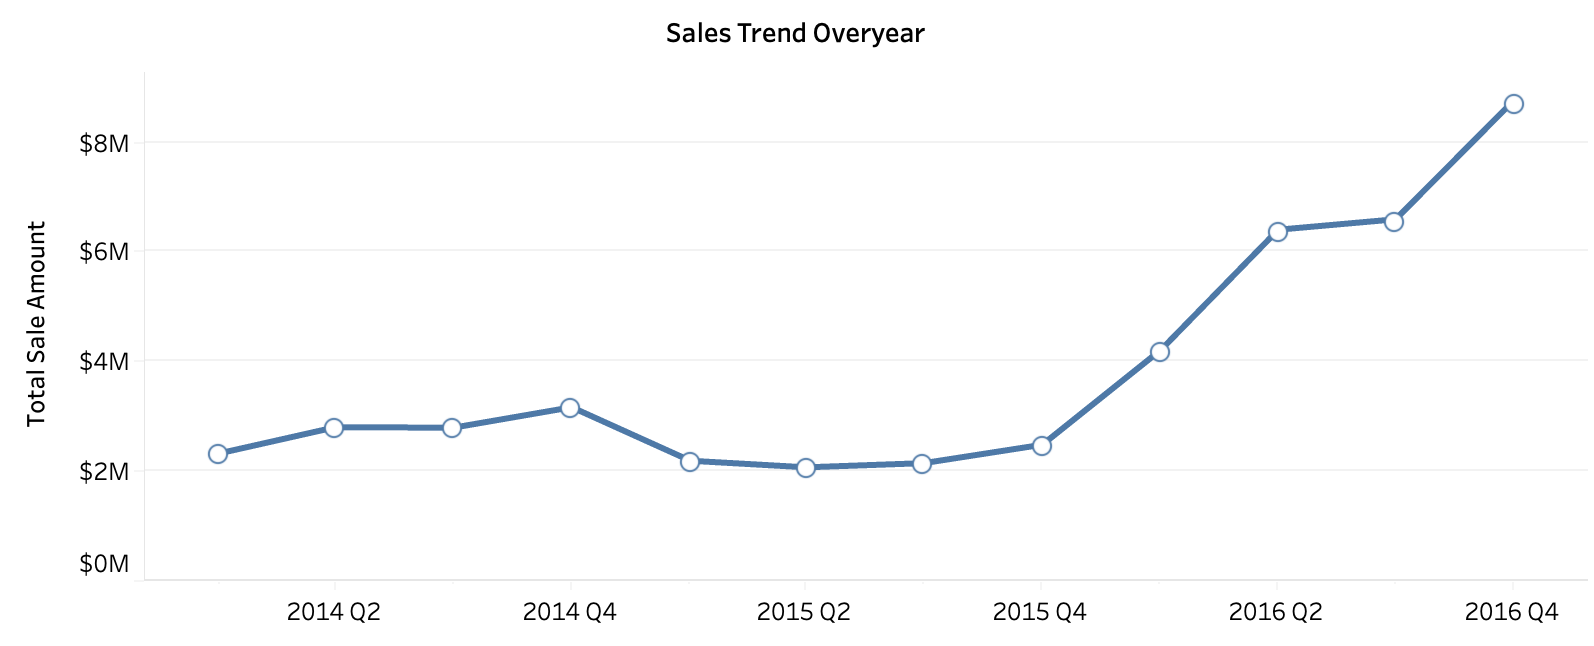

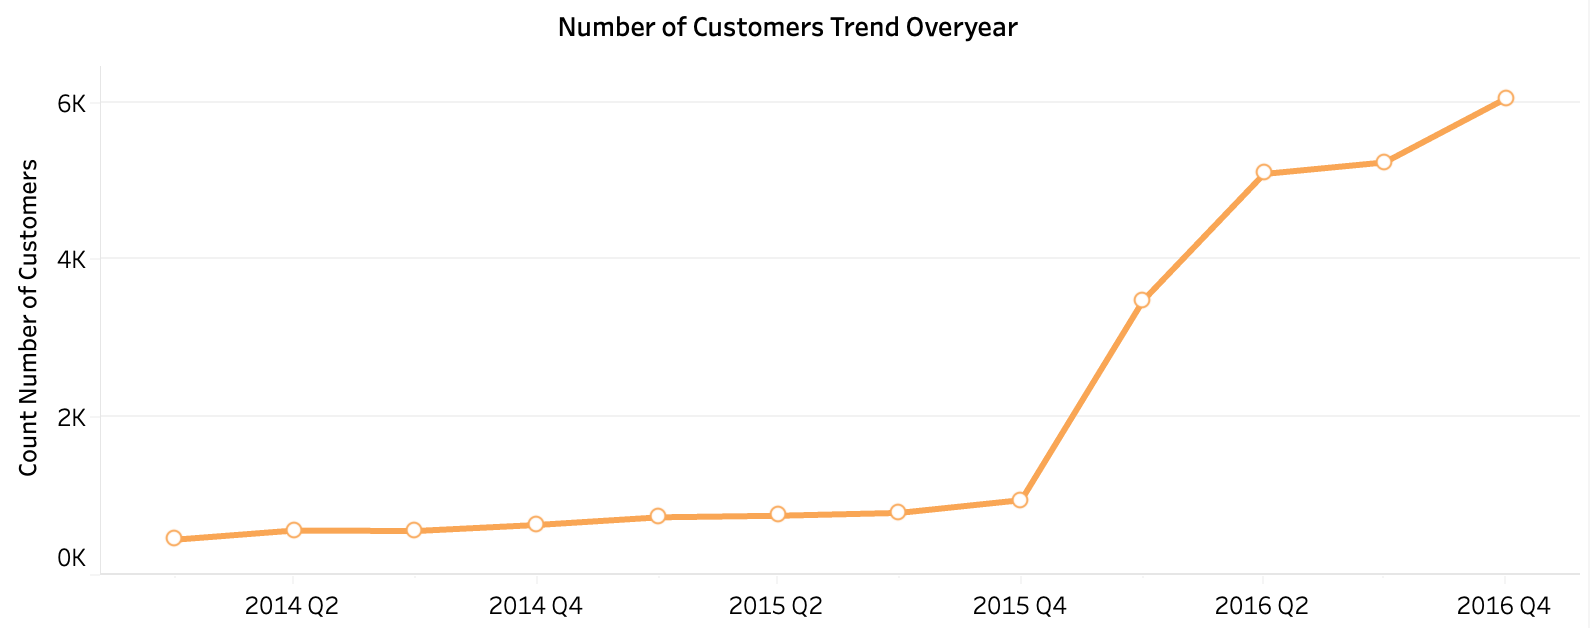

In [24]:
# Total Revenue by Products & Orders

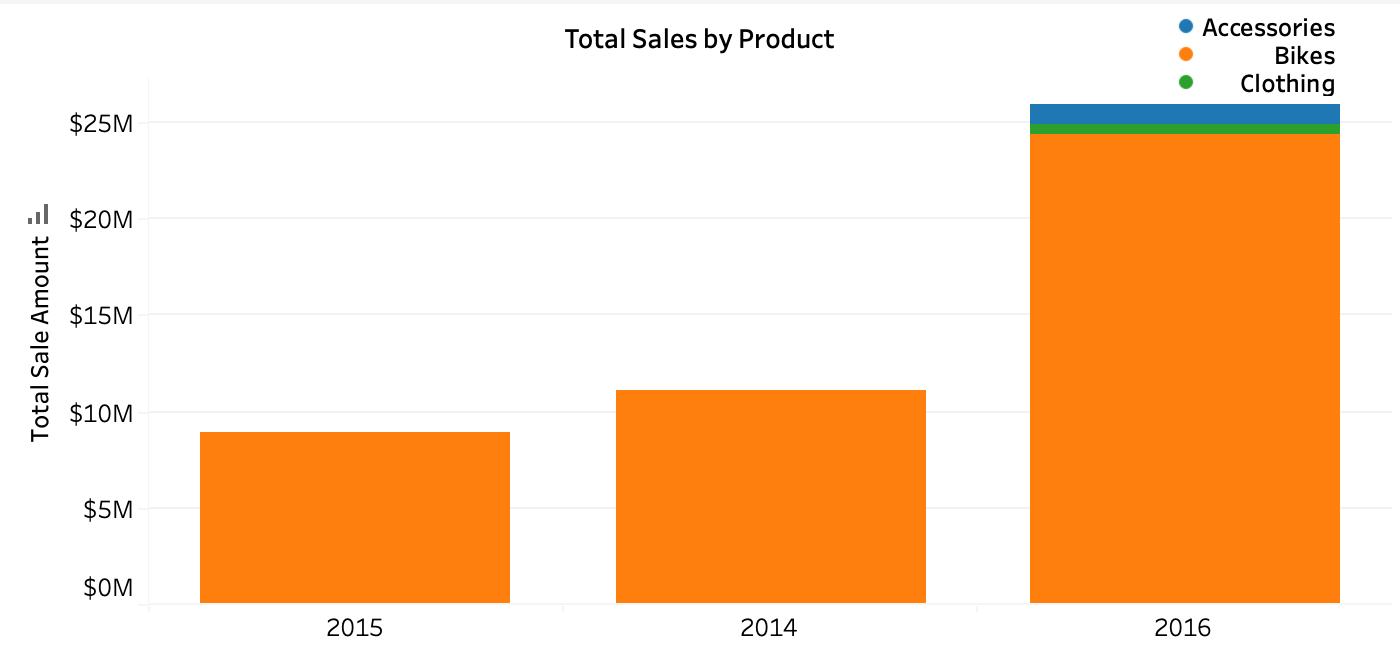

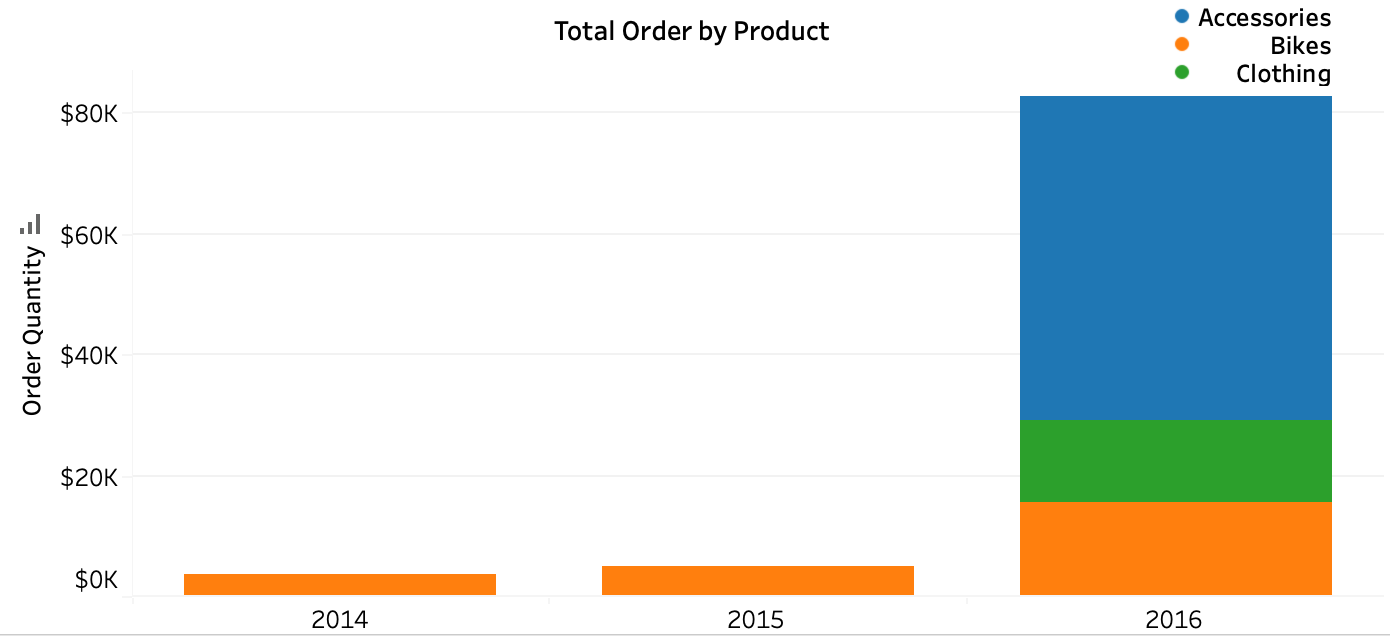

In [25]:
# Total Sales by Product by Region

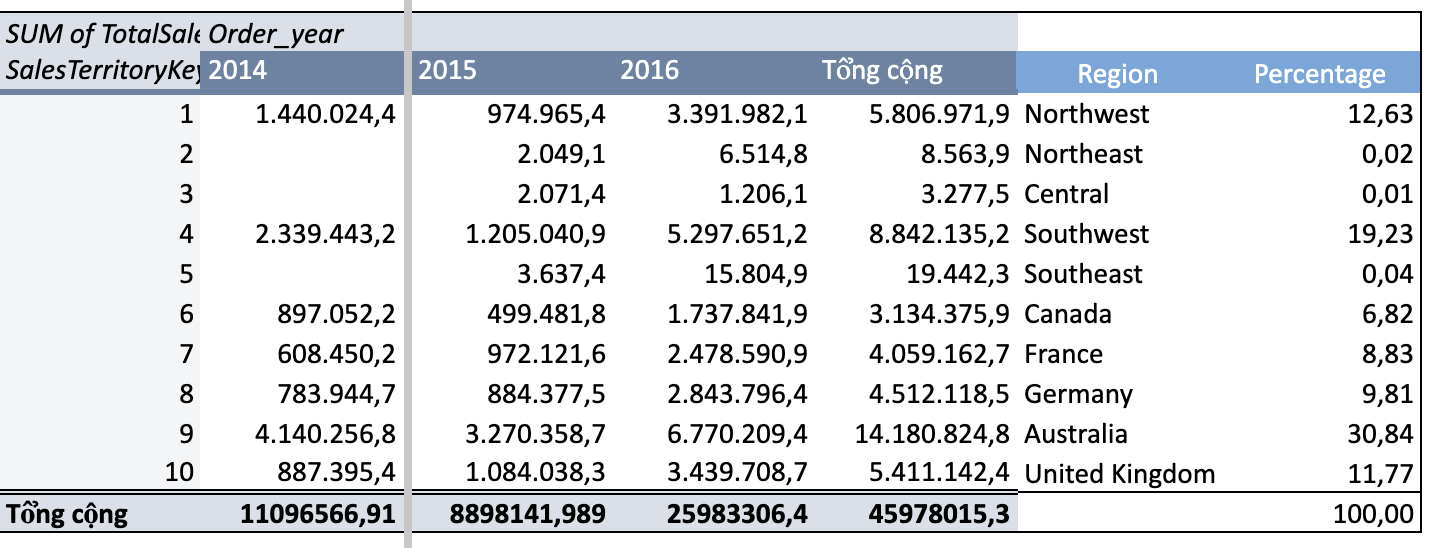

### 1.2/ Time-series Analysis

In [26]:
# Time-series Analysis

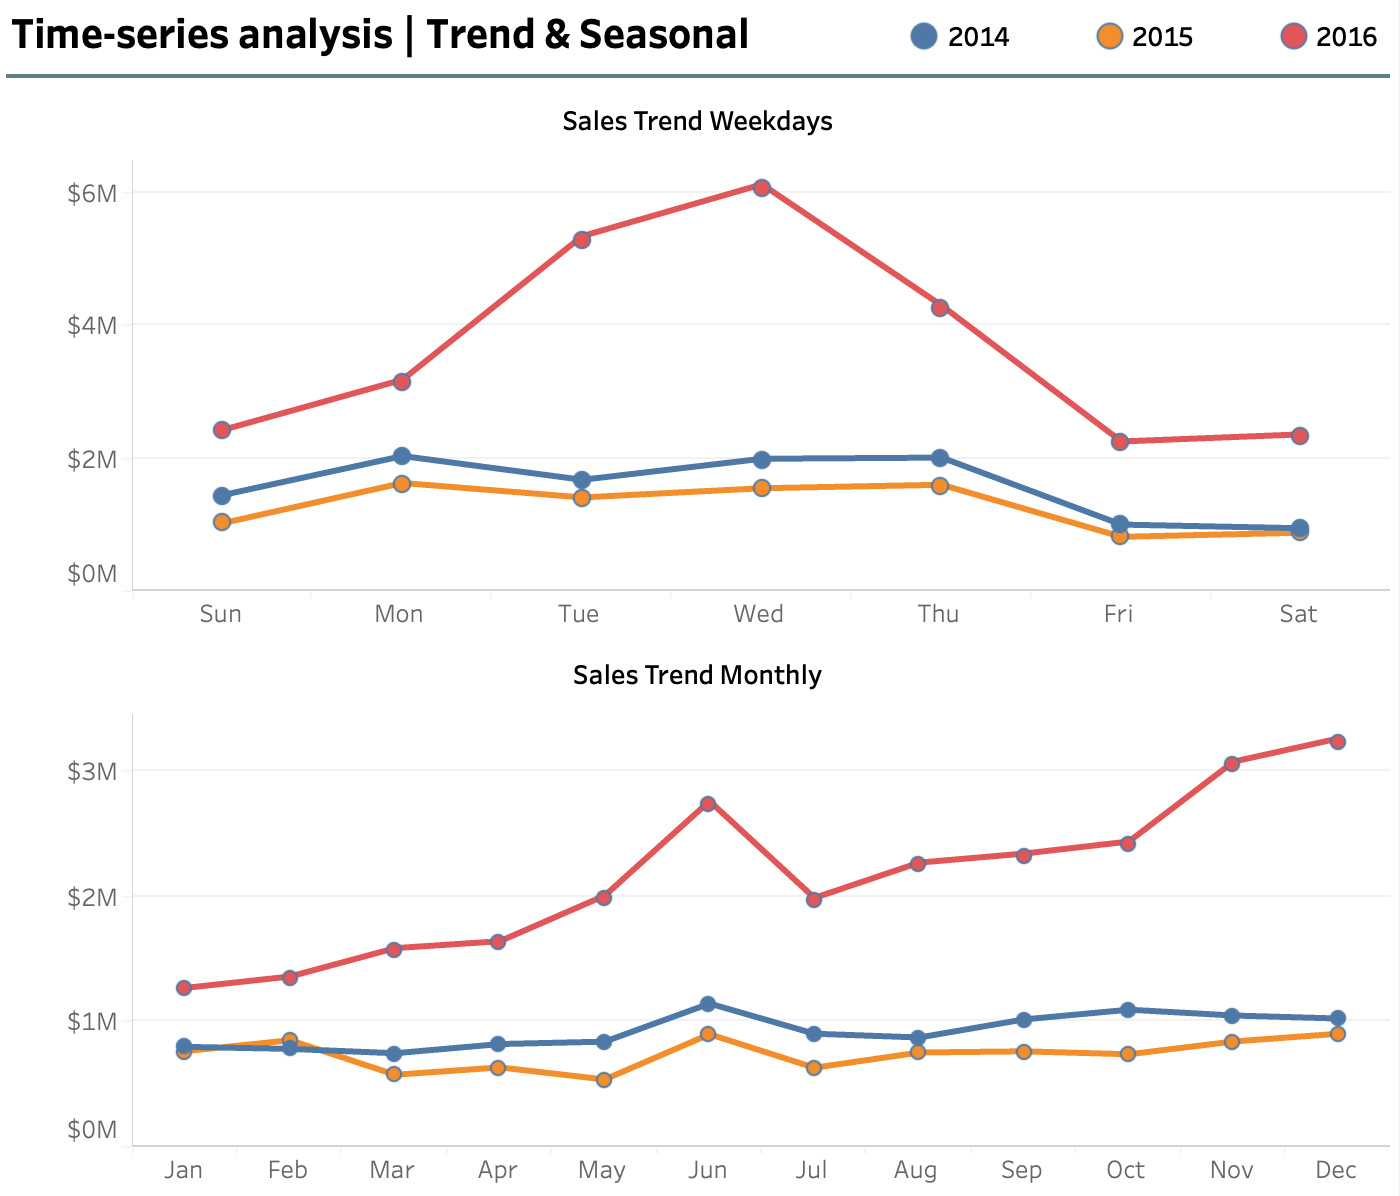

In [27]:
# Sale Peak Time 2016
tableau_url = "https://public.tableau.com/views/Book1_17425364309350/SalePeakTimein2016?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link"
# Display a clickable link
HTML(f'<a href="{tableau_url}" target="_blank">Click here to view Tableau Chart</a>')

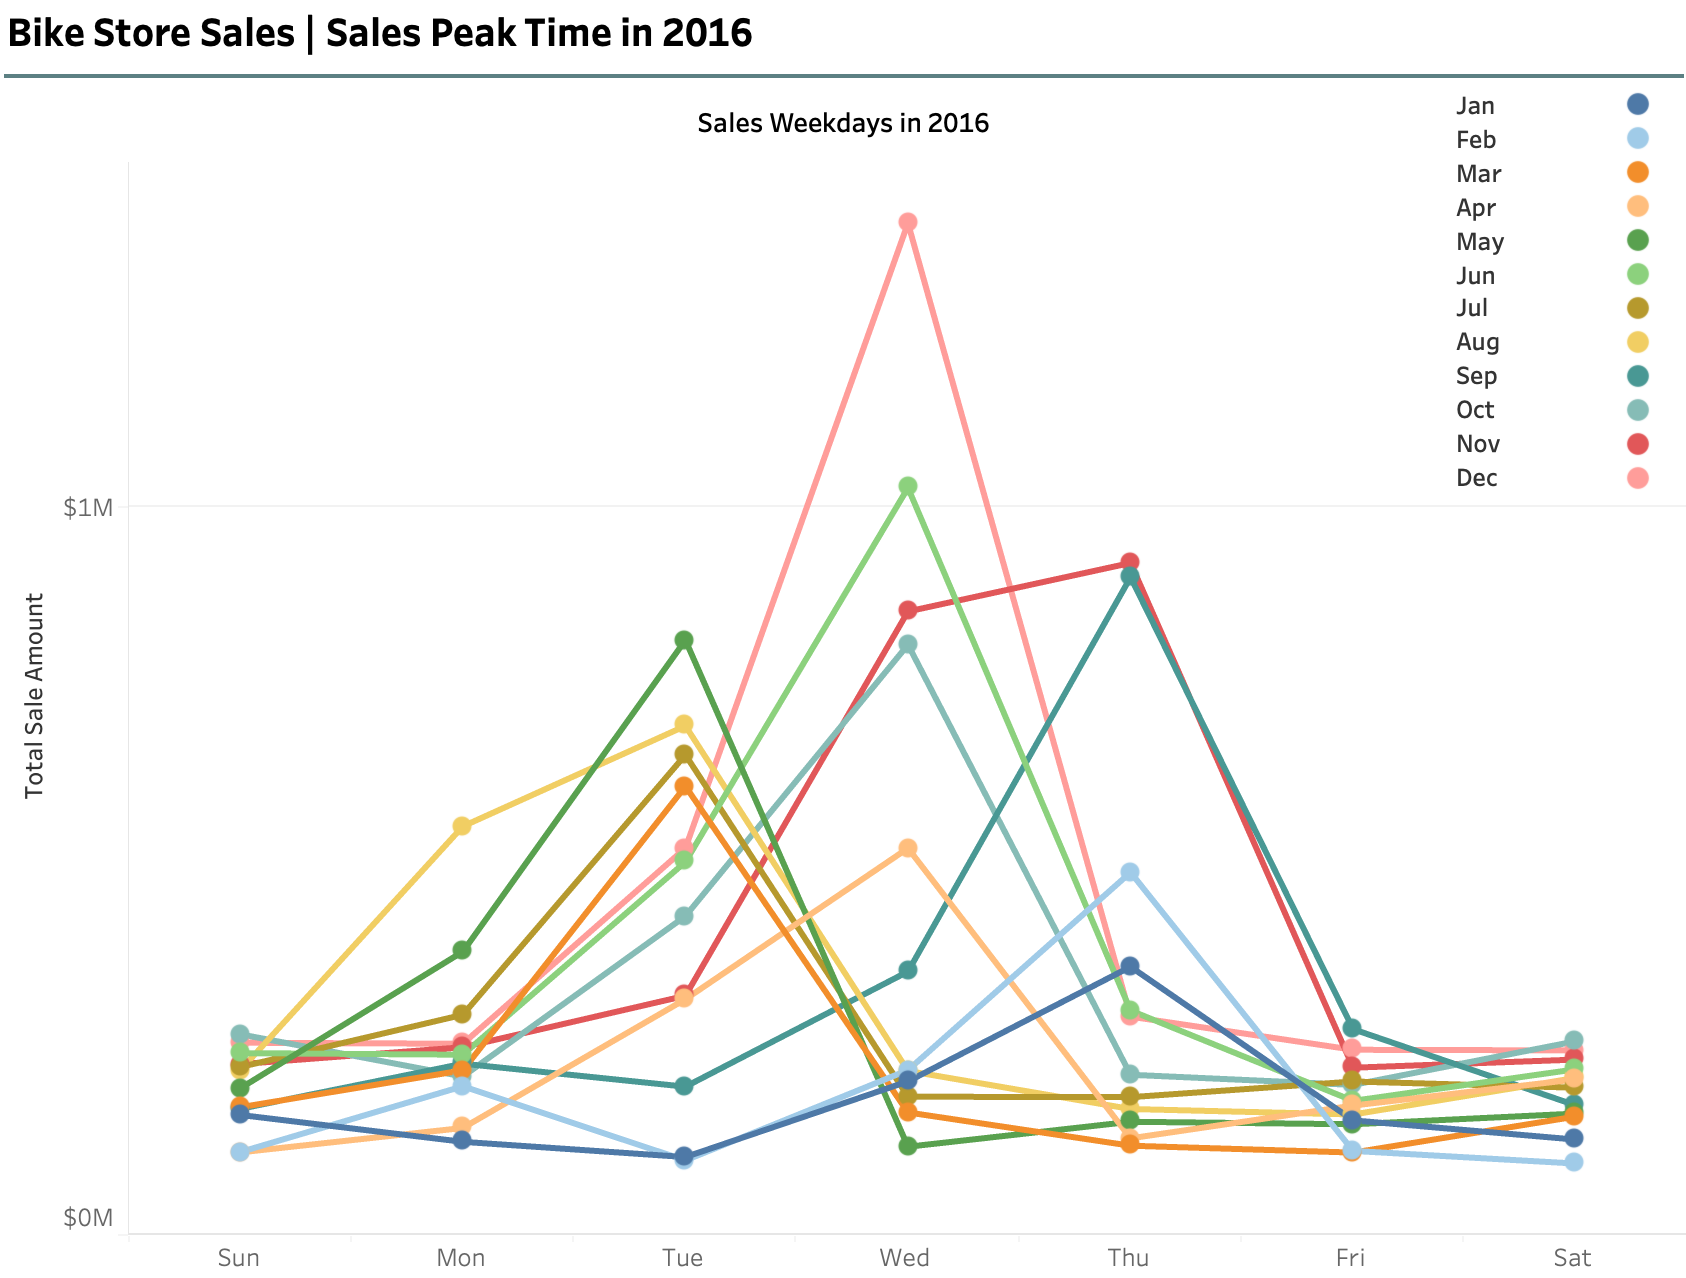

## 2/ Customer Analysis

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  int64         
 2   CustomerKey        58182 non-null  object        
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  int64         
 9   TotalChildren      58182 non-null  int64         
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  int64         
 13  NumberCarsOwned    58182 non-null  int64         
 14  CarOwnerFla

In [29]:
#Customer segment
customer_segement = df.groupby('CustomerKey').agg(FirstTrade = ('Date', 'min'),
                                            LastTrade = ('Date','max'),
                                            TotalVolume = ('TotalSaleAmount', 'sum'),
                                            NumberofTrades = ('TotalSaleAmount', 'count')).reset_index()
customer_segement



CustomerKey FirstTrade  LastTrade  TotalVolume  NumberofTrades
0          11000.0 2014-01-22 2016-05-04        11642               8
1          11001.0 2014-01-18 2016-12-12         8793              11
2          11002.0 2014-01-10 2016-02-27         8111               4
3          11003.0 2014-01-01 2016-05-11        11532               9
4          11004.0 2014-01-26 2016-05-02        10610               6
...            ...        ...        ...          ...             ...
17913      29479.0 2015-09-08 2015-09-08         2049               1
17914      29480.0 2016-07-18 2016-07-18         4880               5
17915      29481.0 2014-08-13 2014-08-13         3374               1
17916      29482.0 2015-09-22 2015-09-22         2049               1
17917      29483.0 2015-09-13 2015-09-13         2049               1

[17918 rows x 5 columns]

In [30]:
# Create a pivot table to sum 'TotalSaleAmount' per Customer Key and Category
df_pivot = pd.pivot_table(data = df,
                          index = 'CustomerKey',
                          columns = 'Category',
                          values = 'TotalSaleAmount',
                          aggfunc = 'sum',
                          fill_value = 0)

# Calculate total spending per customer
df_pivot['TotalSpending'] = df_pivot.sum(axis = 1)

# Calculate the percentage contribution of each category
category_columns = df_pivot.columns[:-1]
df_pivot[category_columns] = (df_pivot[category_columns].div(df_pivot["TotalSpending"], axis=0) * 100).round(2)
df_pivot = df_pivot.drop(columns = 'TotalSpending')
df_pivot

Category     Accessories   Bikes  Clothing
CustomerKey                               
11000.0             0.75   98.80      0.46
11001.0             1.33   97.26      1.41
11002.0             0.42   99.58      0.00
11003.0             0.41   99.52      0.07
11004.0             1.17   98.83      0.00
...                  ...     ...       ...
29479.0             0.00  100.00      0.00
29480.0             1.95   97.70      0.35
29481.0             0.00  100.00      0.00
29482.0             0.00  100.00      0.00
29483.0             0.00  100.00      0.00

[17918 rows x 3 columns]

In [31]:
# customer age group from df to merge to customer_df
customer_age_group = df.groupby('CustomerKey')['AgeGroup'].first().reset_index()
customer_age_group

CustomerKey AgeGroup
0          11000.0    Adult
1          11001.0   Senior
2          11002.0   Senior
3          11003.0    Adult
4          11004.0    Adult
...            ...      ...
17913      29479.0   Senior
17914      29480.0   Senior
17915      29481.0   Senior
17916      29482.0   Senior
17917      29483.0   Senior

[17918 rows x 2 columns]

In [32]:
# Merge customer with customer_segement & df_pivot and customer_age_group
customer_df_1 = pd.merge(customer, customer_segement, on='CustomerKey', how='left')
customer_df_2 = pd.merge(customer_df_1, customer_age_group, on='CustomerKey', how='left')
customer_df = pd.merge(customer_df_2, df_pivot, on='CustomerKey', how='left')
customer_df


CustomerKey  FirstName LastName  BirthDate MaritalStatus Gender  \
0            11000        Jon     Yang 1966-04-08             M      M   
1            11001     Eugene    Huang 1965-05-14             S      M   
2            11002      Ruben   Torres 1965-08-12             M      M   
3            11003    Christy      Zhu 1968-02-15             S      F   
4            11004  Elizabeth  Johnson 1968-08-08             S      F   
...            ...        ...      ...        ...           ...    ...   
18479        29479      Tommy     Tang 1958-07-04             M      M   
18480        29480       Nina     Raji 1960-11-10             S      F   
18481        29481       Ivan     Suri 1960-01-05             S      M   
18482        29482    Clayton    Zhang 1959-03-05             M      M   
18483        29483      Jésus  Navarro 1959-12-08             M      M   

       YearlyIncome  TotalChildren        Education    Occupation  ...  \
0             90000              2        Bachelors  Professional  ...   
1             60000              3        Bachelors  Professional  ...   
2             60000              3        Bachelors  Professional  ...   
3             70000              0        Bachelors  Professional  ...   
4             80000              5        Bachelors  Professional  ...   
...             ...            ...              ...           ...  ...   
18479         30000              1  Graduate Degree      Clerical  ...   
18480         30000              3  Graduate Degree      Clerical  ...   
18481         30000              3  Graduate Degree      Clerical  ...   
18482         30000              3        Bachelors      Clerical  ...   
18483         30000              0        Bachelors      Clerical  ...   

       NumberCarsOwned  CarOwnerFlag  FirstTrade  LastTrade TotalVolume  \
0                    0             0  2014-01-22 2016-05-04     11642.0   
1                    1             1  2014-01-18 2016-12-12      8793.0   
2                    1             1  2014-01-10 2016-02-27      8111.0   
3                    1             1  2014-01-01 2016-05-11     11532.0   
4                    4             2  2014-01-26 2016-05-02     10610.0   
...                ...           ...         ...        ...         ...   
18479                0             0  2015-09-08 2015-09-08      2049.0   
18480                0             0  2016-07-18 2016-07-18      4880.0   
18481                0             0  2014-08-13 2014-08-13      3374.0   
18482                0             0  2015-09-22 2015-09-22      2049.0   
18483                0             0  2015-09-13 2015-09-13      2049.0   

       NumberofTrades  AgeGroup Accessories   Bikes  Clothing  
0                 8.0     Adult        0.75   98.80      0.46  
1                11.0    Senior        1.33   97.26      1.41  
2                 4.0    Senior        0.42   99.58      0.00  
3                 9.0     Adult        0.41   99.52      0.07  
4                 6.0     Adult        1.17   98.83      0.00  
...               ...       ...         ...     ...       ...  
18479             1.0    Senior        0.00  100.00      0.00  
18480             5.0    Senior        1.95   97.70      0.35  
18481             1.0    Senior        0.00  100.00      0.00  
18482             1.0    Senior        0.00  100.00      0.00  
18483             1.0    Senior        0.00  100.00      0.00  

[18484 rows x 21 columns]

In [33]:
# Adjust HouseOwnerFlag to categorical value
customer_df['HouseOwnerFlag'] = customer_df['HouseOwnerFlag'].map({1: 'Yes', 0: 'No'})
customer_df

CustomerKey  FirstName LastName  BirthDate MaritalStatus Gender  \
0            11000        Jon     Yang 1966-04-08             M      M   
1            11001     Eugene    Huang 1965-05-14             S      M   
2            11002      Ruben   Torres 1965-08-12             M      M   
3            11003    Christy      Zhu 1968-02-15             S      F   
4            11004  Elizabeth  Johnson 1968-08-08             S      F   
...            ...        ...      ...        ...           ...    ...   
18479        29479      Tommy     Tang 1958-07-04             M      M   
18480        29480       Nina     Raji 1960-11-10             S      F   
18481        29481       Ivan     Suri 1960-01-05             S      M   
18482        29482    Clayton    Zhang 1959-03-05             M      M   
18483        29483      Jésus  Navarro 1959-12-08             M      M   

       YearlyIncome  TotalChildren        Education    Occupation  ...  \
0             90000              2        Bachelors  Professional  ...   
1             60000              3        Bachelors  Professional  ...   
2             60000              3        Bachelors  Professional  ...   
3             70000              0        Bachelors  Professional  ...   
4             80000              5        Bachelors  Professional  ...   
...             ...            ...              ...           ...  ...   
18479         30000              1  Graduate Degree      Clerical  ...   
18480         30000              3  Graduate Degree      Clerical  ...   
18481         30000              3  Graduate Degree      Clerical  ...   
18482         30000              3        Bachelors      Clerical  ...   
18483         30000              0        Bachelors      Clerical  ...   

      NumberCarsOwned  CarOwnerFlag  FirstTrade  LastTrade TotalVolume  \
0                   0             0  2014-01-22 2016-05-04     11642.0   
1                   1             1  2014-01-18 2016-12-12      8793.0   
2                   1             1  2014-01-10 2016-02-27      8111.0   
3                   1             1  2014-01-01 2016-05-11     11532.0   
4                   4             2  2014-01-26 2016-05-02     10610.0   
...               ...           ...         ...        ...         ...   
18479               0             0  2015-09-08 2015-09-08      2049.0   
18480               0             0  2016-07-18 2016-07-18      4880.0   
18481               0             0  2014-08-13 2014-08-13      3374.0   
18482               0             0  2015-09-22 2015-09-22      2049.0   
18483               0             0  2015-09-13 2015-09-13      2049.0   

       NumberofTrades  AgeGroup Accessories   Bikes  Clothing  
0                 8.0     Adult        0.75   98.80      0.46  
1                11.0    Senior        1.33   97.26      1.41  
2                 4.0    Senior        0.42   99.58      0.00  
3                 9.0     Adult        0.41   99.52      0.07  
4                 6.0     Adult        1.17   98.83      0.00  
...               ...       ...         ...     ...       ...  
18479             1.0    Senior        0.00  100.00      0.00  
18480             5.0    Senior        1.95   97.70      0.35  
18481             1.0    Senior        0.00  100.00      0.00  
18482             1.0    Senior        0.00  100.00      0.00  
18483             1.0    Senior        0.00  100.00      0.00  

[18484 rows x 21 columns]

In [34]:
# drop CarOwnerFlag
customer_df.drop(columns = ['CarOwnerFlag'], inplace = True)

In [35]:
# Check duplicated
customer_df.duplicated().sum()

np.int64(0)

In [36]:
#Check missing values
customer_df.isna().sum()

CustomerKey          0
FirstName            0
LastName             0
BirthDate            0
MaritalStatus        0
Gender               0
YearlyIncome         0
TotalChildren        0
Education            0
Occupation           0
HouseOwnerFlag       0
NumberCarsOwned      0
FirstTrade         566
LastTrade          566
TotalVolume        566
NumberofTrades     566
AgeGroup           566
Accessories        566
Bikes              566
Clothing           566
dtype: int64

In [37]:
# Fill missing values
customer_df['FirstTrade'] = customer_df['FirstTrade'].fillna(customer_df['FirstTrade'].min())
customer_df['LastTrade'] = customer_df['LastTrade'].fillna(customer_df['LastTrade'].max())
customer_df['TotalVolume'] = customer_df['TotalVolume'].fillna(customer_df['TotalVolume'].mean())
customer_df['NumberofTrades'] = customer_df['NumberofTrades'].fillna(customer_df['NumberofTrades'].mean())
customer_df['AgeGroup'] = customer_df['AgeGroup'].fillna(customer_df['AgeGroup'].mode()[0])
customer_df['Accessories'] = customer_df['Accessories'].fillna(customer_df['Accessories'].mode()[0])
customer_df['Bikes'] = customer_df['Bikes'].fillna(customer_df['Bikes'].mode()[0])
customer_df['Clothing'] = customer_df['Clothing'].fillna(customer_df['Clothing'].mode()[0])
customer_df

CustomerKey  FirstName LastName  BirthDate MaritalStatus Gender  \
0            11000        Jon     Yang 1966-04-08             M      M   
1            11001     Eugene    Huang 1965-05-14             S      M   
2            11002      Ruben   Torres 1965-08-12             M      M   
3            11003    Christy      Zhu 1968-02-15             S      F   
4            11004  Elizabeth  Johnson 1968-08-08             S      F   
...            ...        ...      ...        ...           ...    ...   
18479        29479      Tommy     Tang 1958-07-04             M      M   
18480        29480       Nina     Raji 1960-11-10             S      F   
18481        29481       Ivan     Suri 1960-01-05             S      M   
18482        29482    Clayton    Zhang 1959-03-05             M      M   
18483        29483      Jésus  Navarro 1959-12-08             M      M   

       YearlyIncome  TotalChildren        Education    Occupation  \
0             90000              2        Bachelors  Professional   
1             60000              3        Bachelors  Professional   
2             60000              3        Bachelors  Professional   
3             70000              0        Bachelors  Professional   
4             80000              5        Bachelors  Professional   
...             ...            ...              ...           ...   
18479         30000              1  Graduate Degree      Clerical   
18480         30000              3  Graduate Degree      Clerical   
18481         30000              3  Graduate Degree      Clerical   
18482         30000              3        Bachelors      Clerical   
18483         30000              0        Bachelors      Clerical   

      HouseOwnerFlag  NumberCarsOwned FirstTrade  LastTrade  TotalVolume  \
0                Yes                0 2014-01-22 2016-05-04      11642.0   
1                 No                1 2014-01-18 2016-12-12       8793.0   
2                Yes                1 2014-01-10 2016-02-27       8111.0   
3                 No                1 2014-01-01 2016-05-11      11532.0   
4                Yes                4 2014-01-26 2016-05-02      10610.0   
...              ...              ...        ...        ...          ...   
18479            Yes                0 2015-09-08 2015-09-08       2049.0   
18480            Yes                0 2016-07-18 2016-07-18       4880.0   
18481             No                0 2014-08-13 2014-08-13       3374.0   
18482            Yes                0 2015-09-22 2015-09-22       2049.0   
18483            Yes                0 2015-09-13 2015-09-13       2049.0   

       NumberofTrades AgeGroup  Accessories   Bikes  Clothing  
0                 8.0    Adult         0.75   98.80      0.46  
1                11.0   Senior         1.33   97.26      1.41  
2                 4.0   Senior         0.42   99.58      0.00  
3                 9.0    Adult         0.41   99.52      0.07  
4                 6.0    Adult         1.17   98.83      0.00  
...               ...      ...          ...     ...       ...  
18479             1.0   Senior         0.00  100.00      0.00  
18480             5.0   Senior         1.95   97.70      0.35  
18481             1.0   Senior         0.00  100.00      0.00  
18482             1.0   Senior         0.00  100.00      0.00  
18483             1.0   Senior         0.00  100.00      0.00  

[18484 rows x 20 columns]

In [38]:
# Change MartialStatus to be clear
customer_df['MaritalStatus'] = customer_df['MaritalStatus'].map({'M': 'Married', 'S': 'Single'})

# Change Gender
customer_df['Gender'] = customer_df['Gender'].map({'M': 'Male', 'F': 'Female'})

In [39]:
# Define a function to categorize car ownership
def categorize_cars(num):
    if num == 0:
        return "Not Owned Car"
    elif num == 1:
        return "Owned 1 Car"
    else:
        return "Owned Over 2 Cars"

# Apply the function to create a new categorical column
customer_df["CarsOwned"] = customer_df["NumberCarsOwned"].apply(categorize_cars)
customer_df

CustomerKey  FirstName LastName  BirthDate MaritalStatus  Gender  \
0            11000        Jon     Yang 1966-04-08       Married    Male   
1            11001     Eugene    Huang 1965-05-14        Single    Male   
2            11002      Ruben   Torres 1965-08-12       Married    Male   
3            11003    Christy      Zhu 1968-02-15        Single  Female   
4            11004  Elizabeth  Johnson 1968-08-08        Single  Female   
...            ...        ...      ...        ...           ...     ...   
18479        29479      Tommy     Tang 1958-07-04       Married    Male   
18480        29480       Nina     Raji 1960-11-10        Single  Female   
18481        29481       Ivan     Suri 1960-01-05        Single    Male   
18482        29482    Clayton    Zhang 1959-03-05       Married    Male   
18483        29483      Jésus  Navarro 1959-12-08       Married    Male   

       YearlyIncome  TotalChildren        Education    Occupation  ...  \
0             90000              2        Bachelors  Professional  ...   
1             60000              3        Bachelors  Professional  ...   
2             60000              3        Bachelors  Professional  ...   
3             70000              0        Bachelors  Professional  ...   
4             80000              5        Bachelors  Professional  ...   
...             ...            ...              ...           ...  ...   
18479         30000              1  Graduate Degree      Clerical  ...   
18480         30000              3  Graduate Degree      Clerical  ...   
18481         30000              3  Graduate Degree      Clerical  ...   
18482         30000              3        Bachelors      Clerical  ...   
18483         30000              0        Bachelors      Clerical  ...   

      NumberCarsOwned  FirstTrade  LastTrade TotalVolume  NumberofTrades  \
0                   0  2014-01-22 2016-05-04     11642.0             8.0   
1                   1  2014-01-18 2016-12-12      8793.0            11.0   
2                   1  2014-01-10 2016-02-27      8111.0             4.0   
3                   1  2014-01-01 2016-05-11     11532.0             9.0   
4                   4  2014-01-26 2016-05-02     10610.0             6.0   
...               ...         ...        ...         ...             ...   
18479               0  2015-09-08 2015-09-08      2049.0             1.0   
18480               0  2016-07-18 2016-07-18      4880.0             5.0   
18481               0  2014-08-13 2014-08-13      3374.0             1.0   
18482               0  2015-09-22 2015-09-22      2049.0             1.0   
18483               0  2015-09-13 2015-09-13      2049.0             1.0   

       AgeGroup Accessories   Bikes  Clothing          CarsOwned  
0         Adult        0.75   98.80      0.46      Not Owned Car  
1        Senior        1.33   97.26      1.41        Owned 1 Car  
2        Senior        0.42   99.58      0.00        Owned 1 Car  
3         Adult        0.41   99.52      0.07        Owned 1 Car  
4         Adult        1.17   98.83      0.00  Owned Over 2 Cars  
...         ...         ...     ...       ...                ...  
18479    Senior        0.00  100.00      0.00      Not Owned Car  
18480    Senior        1.95   97.70      0.35      Not Owned Car  
18481    Senior        0.00  100.00      0.00      Not Owned Car  
18482    Senior        0.00  100.00      0.00      Not Owned Car  
18483    Senior        0.00  100.00      0.00      Not Owned Car  

[18484 rows x 21 columns]

In [40]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerKey      18484 non-null  int64         
 1   FirstName        18484 non-null  object        
 2   LastName         18484 non-null  object        
 3   BirthDate        18484 non-null  datetime64[ns]
 4   MaritalStatus    18484 non-null  object        
 5   Gender           18484 non-null  object        
 6   YearlyIncome     18484 non-null  int64         
 7   TotalChildren    18484 non-null  int64         
 8   Education        18484 non-null  object        
 9   Occupation       18484 non-null  object        
 10  HouseOwnerFlag   18484 non-null  object        
 11  NumberCarsOwned  18484 non-null  int64         
 12  FirstTrade       18484 non-null  datetime64[ns]
 13  LastTrade        18484 non-null  datetime64[ns]
 14  TotalVolume      18484 non-null  float

In [41]:
# Change customer_df datatypes
customer_df['BirthDate'] = pd.to_datetime(customer_df['BirthDate'])
customer_df['BirthDate'] = pd.to_datetime(customer_df['BirthDate'])
customer_df['FirstTrade'] = pd.to_datetime(customer_df['FirstTrade'])

In [42]:
customer_df

CustomerKey  FirstName LastName  BirthDate MaritalStatus  Gender  \
0            11000        Jon     Yang 1966-04-08       Married    Male   
1            11001     Eugene    Huang 1965-05-14        Single    Male   
2            11002      Ruben   Torres 1965-08-12       Married    Male   
3            11003    Christy      Zhu 1968-02-15        Single  Female   
4            11004  Elizabeth  Johnson 1968-08-08        Single  Female   
...            ...        ...      ...        ...           ...     ...   
18479        29479      Tommy     Tang 1958-07-04       Married    Male   
18480        29480       Nina     Raji 1960-11-10        Single  Female   
18481        29481       Ivan     Suri 1960-01-05        Single    Male   
18482        29482    Clayton    Zhang 1959-03-05       Married    Male   
18483        29483      Jésus  Navarro 1959-12-08       Married    Male   

       YearlyIncome  TotalChildren        Education    Occupation  ...  \
0             90000              2        Bachelors  Professional  ...   
1             60000              3        Bachelors  Professional  ...   
2             60000              3        Bachelors  Professional  ...   
3             70000              0        Bachelors  Professional  ...   
4             80000              5        Bachelors  Professional  ...   
...             ...            ...              ...           ...  ...   
18479         30000              1  Graduate Degree      Clerical  ...   
18480         30000              3  Graduate Degree      Clerical  ...   
18481         30000              3  Graduate Degree      Clerical  ...   
18482         30000              3        Bachelors      Clerical  ...   
18483         30000              0        Bachelors      Clerical  ...   

      NumberCarsOwned  FirstTrade  LastTrade TotalVolume  NumberofTrades  \
0                   0  2014-01-22 2016-05-04     11642.0             8.0   
1                   1  2014-01-18 2016-12-12      8793.0            11.0   
2                   1  2014-01-10 2016-02-27      8111.0             4.0   
3                   1  2014-01-01 2016-05-11     11532.0             9.0   
4                   4  2014-01-26 2016-05-02     10610.0             6.0   
...               ...         ...        ...         ...             ...   
18479               0  2015-09-08 2015-09-08      2049.0             1.0   
18480               0  2016-07-18 2016-07-18      4880.0             5.0   
18481               0  2014-08-13 2014-08-13      3374.0             1.0   
18482               0  2015-09-22 2015-09-22      2049.0             1.0   
18483               0  2015-09-13 2015-09-13      2049.0             1.0   

       AgeGroup Accessories   Bikes  Clothing          CarsOwned  
0         Adult        0.75   98.80      0.46      Not Owned Car  
1        Senior        1.33   97.26      1.41        Owned 1 Car  
2        Senior        0.42   99.58      0.00        Owned 1 Car  
3         Adult        0.41   99.52      0.07        Owned 1 Car  
4         Adult        1.17   98.83      0.00  Owned Over 2 Cars  
...         ...         ...     ...       ...                ...  
18479    Senior        0.00  100.00      0.00      Not Owned Car  
18480    Senior        1.95   97.70      0.35      Not Owned Car  
18481    Senior        0.00  100.00      0.00      Not Owned Car  
18482    Senior        0.00  100.00      0.00      Not Owned Car  
18483    Senior        0.00  100.00      0.00      Not Owned Car  

[18484 rows x 21 columns]

### 2.1/ Overview

In [43]:
customer_df.describe()

CustomerKey                      BirthDate   YearlyIncome  \
count  18484.000000                          18484   18484.000000   
mean   20241.500000  1962-01-27 20:37:36.135035712   57305.777970   
min    11000.000000            1910-08-13 00:00:00   10000.000000   
25%    15620.750000            1954-09-10 18:00:00   30000.000000   
50%    20241.500000            1963-08-14 00:00:00   60000.000000   
75%    24862.250000            1970-09-26 00:00:00   70000.000000   
max    29483.000000            1980-12-26 00:00:00  170000.000000   
std     5336.015523                            NaN   32285.841703   

       TotalChildren  NumberCarsOwned                     FirstTrade  \
count   18484.000000     18484.000000                          18484   
mean        1.844352         1.502705  2016-01-15 02:07:59.896126464   
min         0.000000         0.000000            2014-01-01 00:00:00   
25%         0.000000         1.000000            2015-08-13 00:00:00   
50%         2.000000         2.000000            2016-04-20 00:00:00   
75%         3.000000         2.000000            2016-08-26 00:00:00   
max         5.000000         4.000000            2016-12-30 00:00:00   
std         1.612408         1.138394                            NaN   

                           LastTrade   TotalVolume  NumberofTrades  \
count                          18484  18484.000000    18484.000000   
mean   2016-07-21 06:46:30.564812800   2563.423262        3.247126   
min              2014-01-01 00:00:00      2.000000        1.000000   
25%              2016-05-09 00:00:00     67.000000        2.000000   
50%              2016-08-12 00:00:00    585.000000        3.000000   
75%              2016-11-03 00:00:00   3578.000000        4.000000   
max              2016-12-30 00:00:00  35880.000000       63.000000   
std                              NaN   3843.383479        2.469636   

        Accessories         Bikes      Clothing  
count  18484.000000  18484.000000  18484.000000  
mean      40.140378     48.319581     11.540057  
min        0.000000      0.000000      0.000000  
25%        0.530000      0.000000      0.000000  
50%        4.380000      0.000000      0.000000  
75%      100.000000     98.590000      1.990000  
max      100.000000    100.000000    100.000000  
std       45.476996     48.938638     26.760845

In [44]:
# Customers Overview

# Tableau Public link
tableau_url = "https://public.tableau.com/views/Customer_dfOverview/CustomerOverview?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link"
# Display a clickable link
HTML(f'<a href="{tableau_url}" target="_blank">Click here to view Tableau Chart</a>')




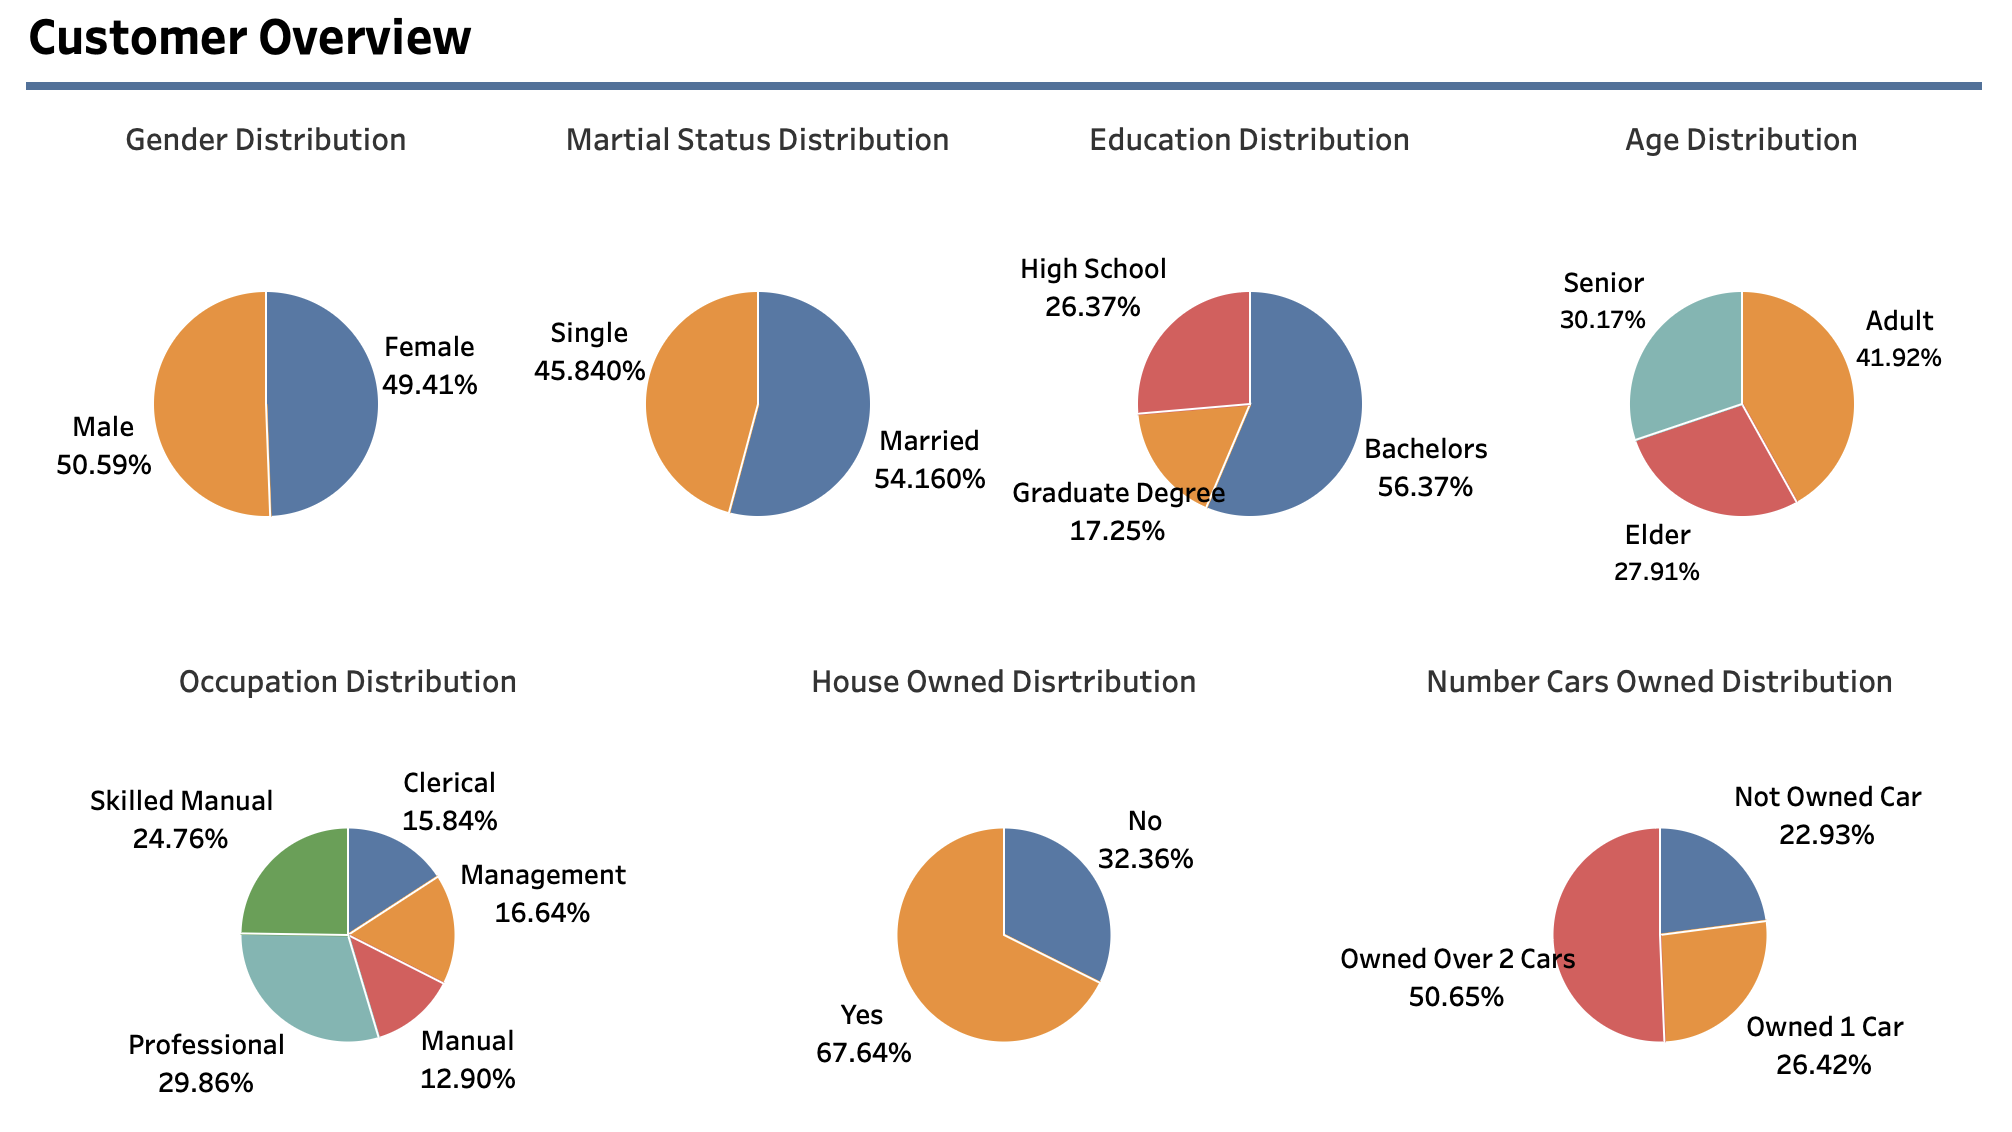

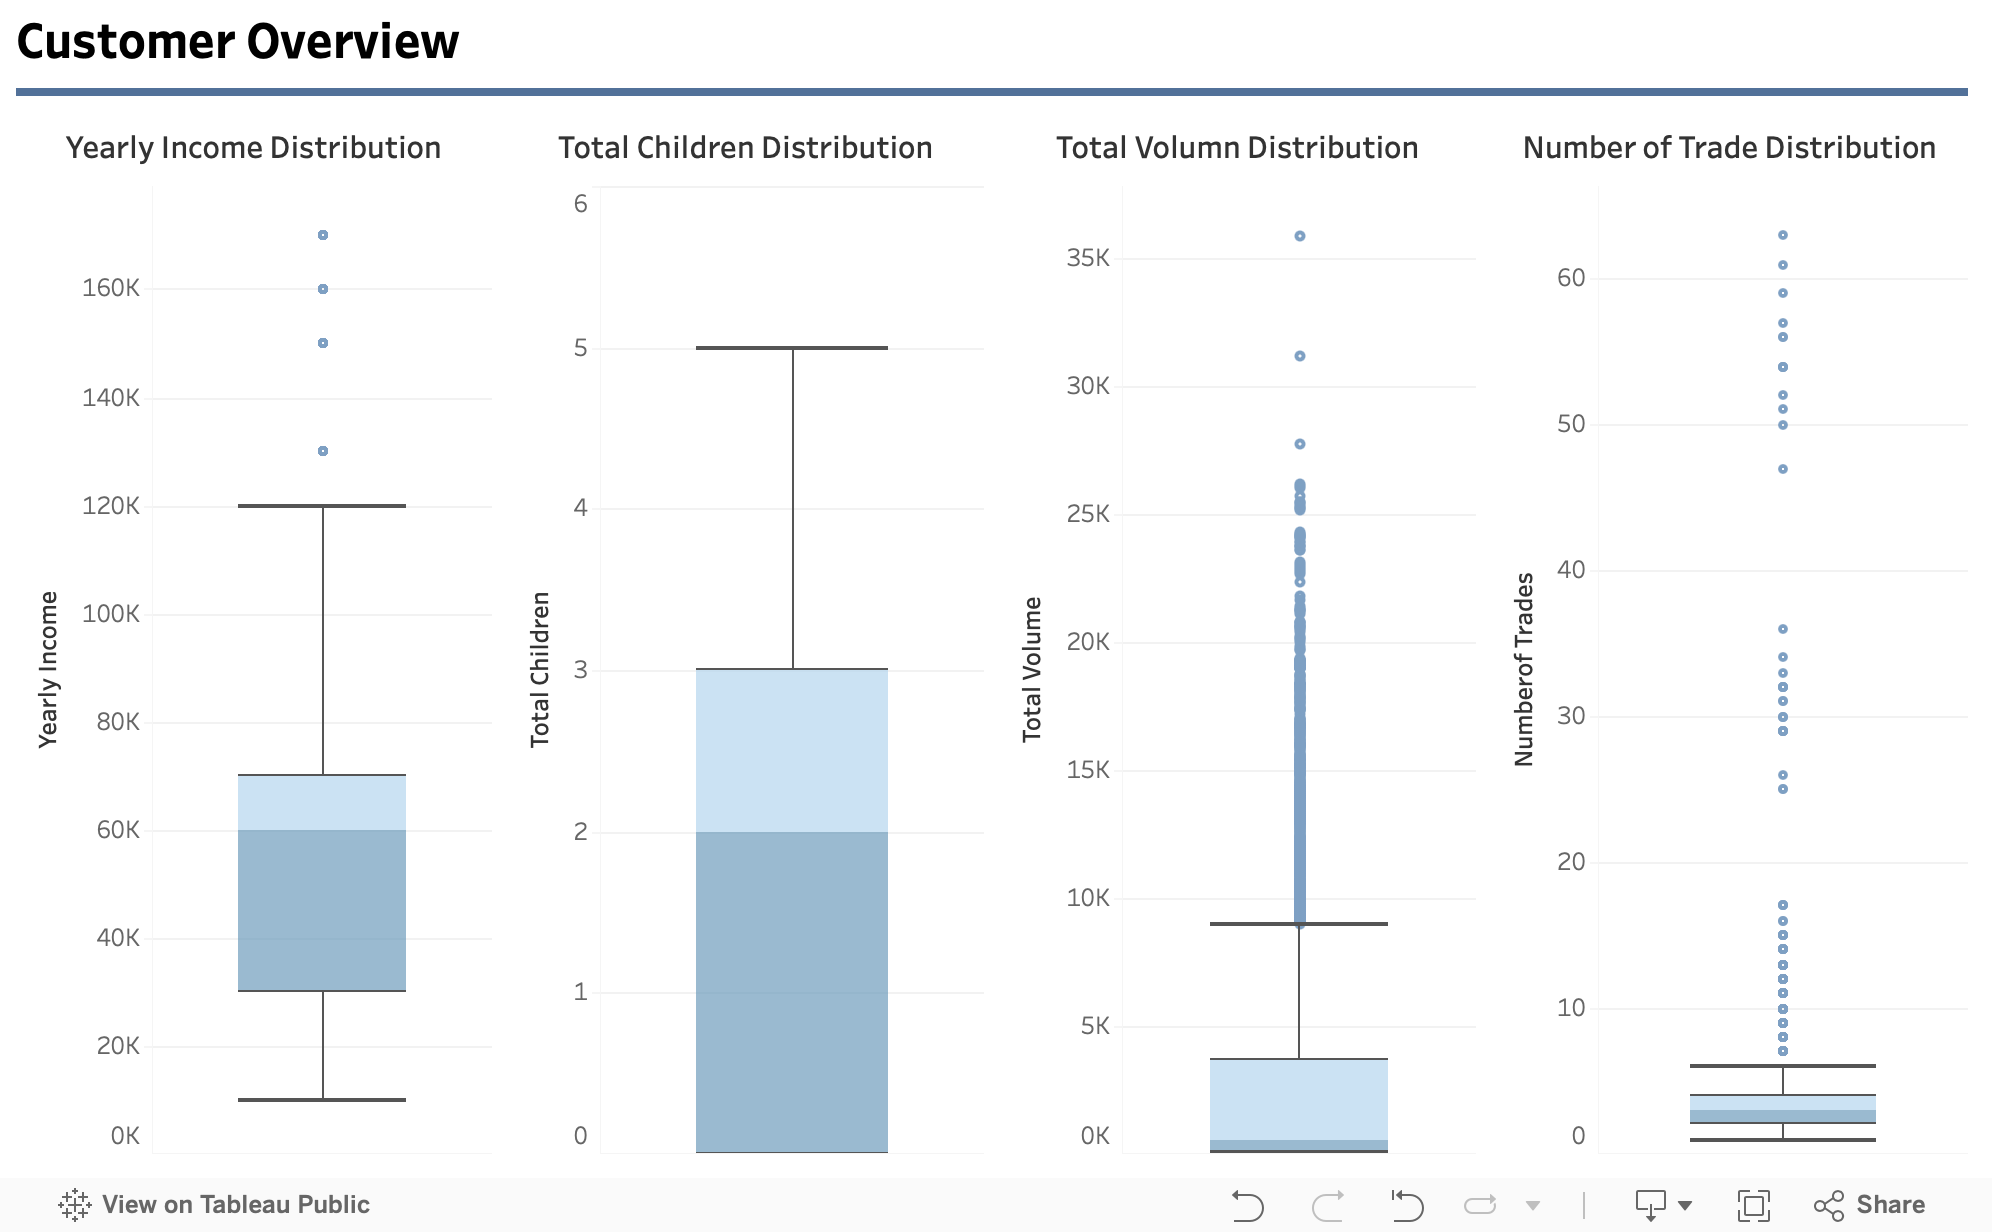

### 2.2/ Correlation

In [45]:
# Correlation
customer_df_correlation = customer_df.drop(columns=['CustomerKey']).corr(numeric_only=True).style.background_gradient(cmap='coolwarm')
customer_df_correlation

In [46]:
customer_df.head()

CustomerKey  FirstName LastName  BirthDate MaritalStatus  Gender  \
0        11000        Jon     Yang 1966-04-08       Married    Male   
1        11001     Eugene    Huang 1965-05-14        Single    Male   
2        11002      Ruben   Torres 1965-08-12       Married    Male   
3        11003    Christy      Zhu 1968-02-15        Single  Female   
4        11004  Elizabeth  Johnson 1968-08-08        Single  Female   

   YearlyIncome  TotalChildren  Education    Occupation  ... NumberCarsOwned  \
0         90000              2  Bachelors  Professional  ...               0   
1         60000              3  Bachelors  Professional  ...               1   
2         60000              3  Bachelors  Professional  ...               1   
3         70000              0  Bachelors  Professional  ...               1   
4         80000              5  Bachelors  Professional  ...               4   

   FirstTrade  LastTrade TotalVolume  NumberofTrades  AgeGroup Accessories  \
0  2014-01-22 2016-05-04     11642.0             8.0     Adult        0.75   
1  2014-01-18 2016-12-12      8793.0            11.0    Senior        1.33   
2  2014-01-10 2016-02-27      8111.0             4.0    Senior        0.42   
3  2014-01-01 2016-05-11     11532.0             9.0     Adult        0.41   
4  2014-01-26 2016-05-02     10610.0             6.0     Adult        1.17   

   Bikes  Clothing          CarsOwned  
0  98.80      0.46      Not Owned Car  
1  97.26      1.41        Owned 1 Car  
2  99.58      0.00        Owned 1 Car  
3  99.52      0.07        Owned 1 Car  
4  98.83      0.00  Owned Over 2 Cars  

[5 rows x 21 columns]

# III/ Exploratory Data Analysis

In [47]:
# Customer Retention Rate

tableau_url = "https://public.tableau.com/views/Book1_17425364309350/Dashboard7?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link"
# Display a clickable link
HTML(f'<a href="{tableau_url}" target="_blank">Click here to view Tableau Chart</a>')

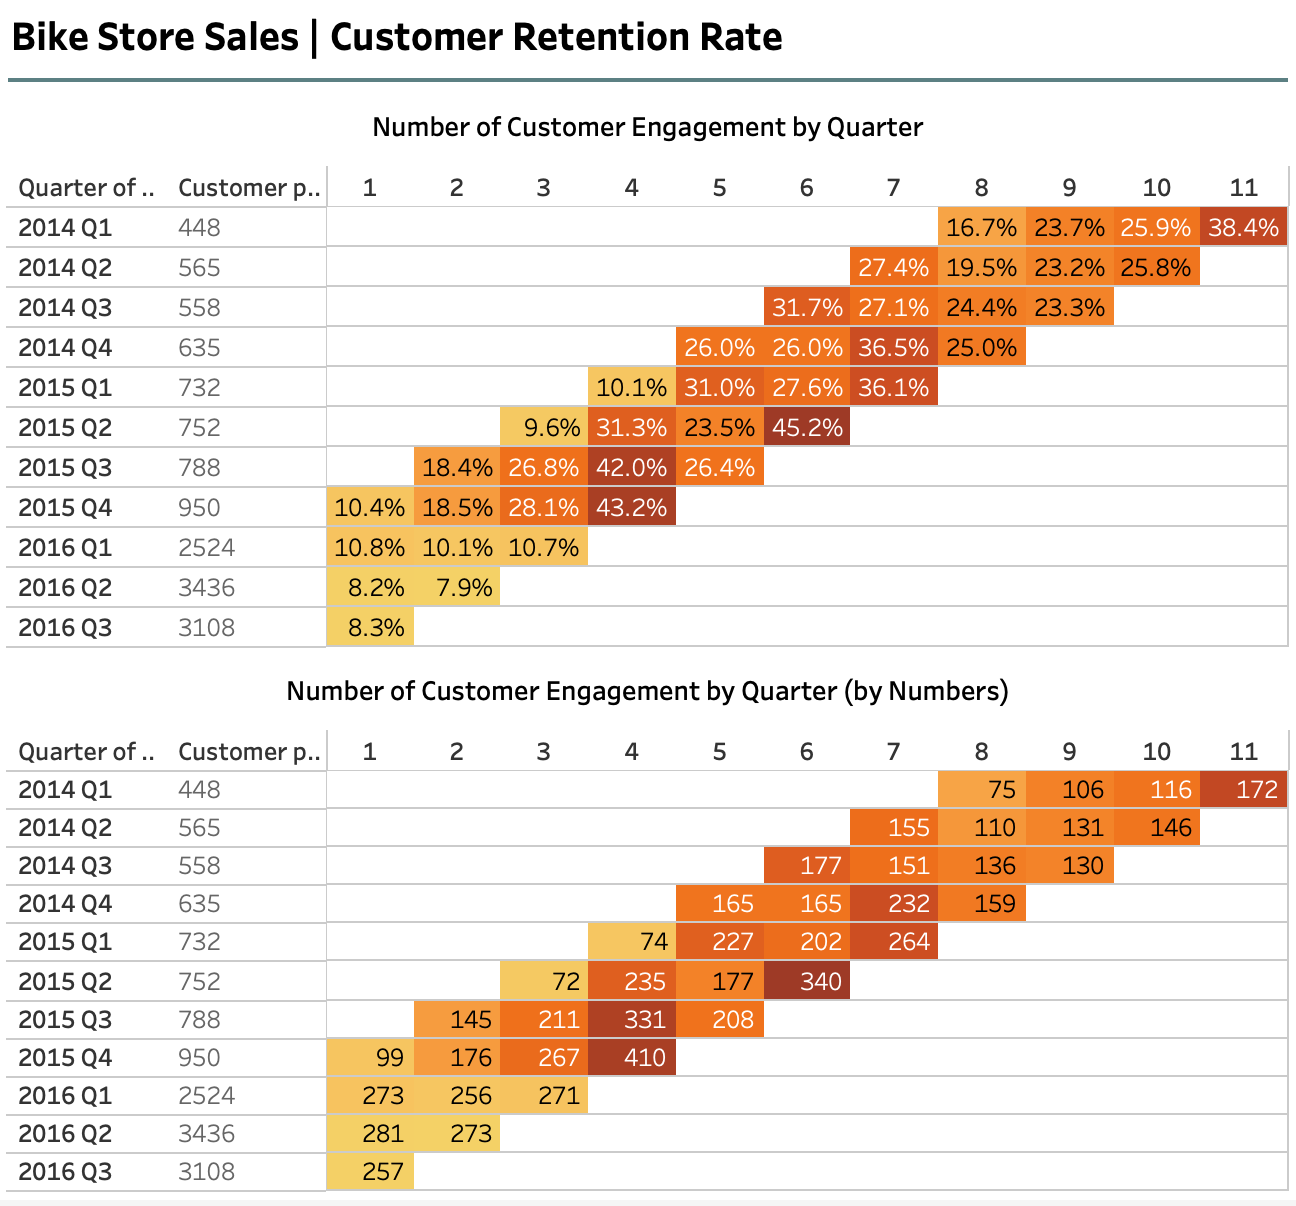

## 1/ Customer Segments

In [48]:
# Add Category column from df to customer_df
first_product_df = df.sort_values(by="Date").groupby("CustomerKey").first().reset_index()
customer_df = customer_df.merge(first_product_df[["CustomerKey", "Category", "SubCategory"]], on="CustomerKey", how="left")
customer_df = customer_df.rename(columns={"Category": "first_product", "SubCategory": "first_sub_product_category"})


In [49]:
customer_df = customer_df.rename(columns={"Accessories": "percentage_accessories_sale", "Bikes": "percentage_bike_sale", "Clothing": "percentage_clothing_sale"})

In [50]:
customer_df.head()

CustomerKey  FirstName LastName  BirthDate MaritalStatus  Gender  \
0        11000        Jon     Yang 1966-04-08       Married    Male   
1        11001     Eugene    Huang 1965-05-14        Single    Male   
2        11002      Ruben   Torres 1965-08-12       Married    Male   
3        11003    Christy      Zhu 1968-02-15        Single  Female   
4        11004  Elizabeth  Johnson 1968-08-08        Single  Female   

   YearlyIncome  TotalChildren  Education    Occupation  ...  LastTrade  \
0         90000              2  Bachelors  Professional  ... 2016-05-04   
1         60000              3  Bachelors  Professional  ... 2016-12-12   
2         60000              3  Bachelors  Professional  ... 2016-02-27   
3         70000              0  Bachelors  Professional  ... 2016-05-11   
4         80000              5  Bachelors  Professional  ... 2016-05-02   

   TotalVolume NumberofTrades AgeGroup  percentage_accessories_sale  \
0      11642.0            8.0    Adult                         0.75   
1       8793.0           11.0   Senior                         1.33   
2       8111.0            4.0   Senior                         0.42   
3      11532.0            9.0    Adult                         0.41   
4      10610.0            6.0    Adult                         1.17   

   percentage_bike_sale percentage_clothing_sale          CarsOwned  \
0                 98.80                     0.46      Not Owned Car   
1                 97.26                     1.41        Owned 1 Car   
2                 99.58                     0.00        Owned 1 Car   
3                 99.52                     0.07        Owned 1 Car   
4                 98.83                     0.00  Owned Over 2 Cars   

   first_product  first_sub_product_category  
0          Bikes              Mountain Bikes  
1          Bikes              Mountain Bikes  
2          Bikes              Mountain Bikes  
3          Bikes              Mountain Bikes  
4          Bikes              Mountain Bikes  

[5 rows x 23 columns]

In [51]:
old_customers = customer_df[customer_df['FirstTrade'] < '2016-01-01']
new_customers = customer_df[(customer_df['FirstTrade'] >= '2016-01-01')]

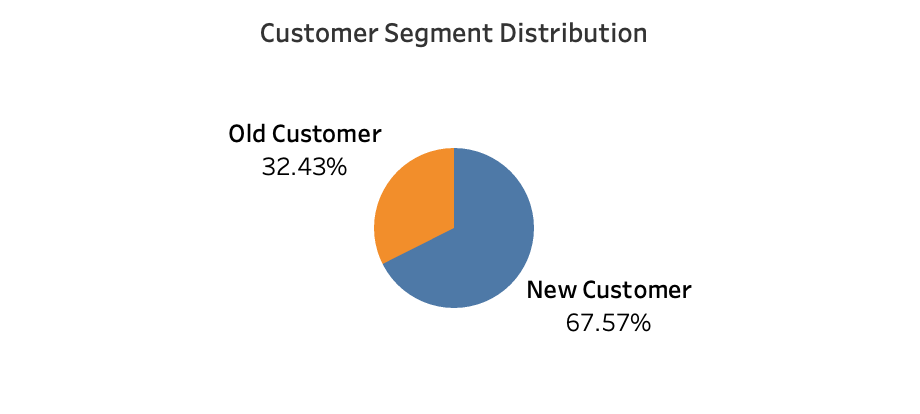

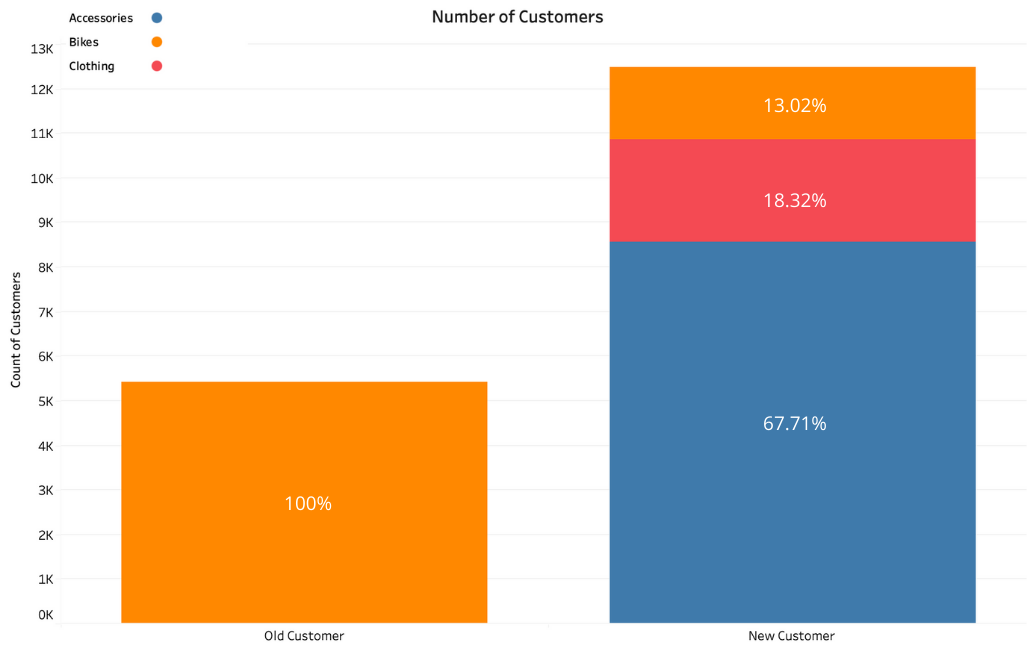

In [52]:
# select new customers buy bike firstly
new_customers_bike_first = new_customers[new_customers['first_product'] == 'Bikes'].reset_index(drop = True)
new_customers_bike_first.head()

CustomerKey FirstName LastName  BirthDate MaritalStatus  Gender  \
0        11036  Jennifer  Russell 1978-12-18       Married  Female   
1        11041    Amanda   Carter 1977-10-16       Married  Female   
2        11042     Megan  Sanchez 1977-06-13       Married  Female   
3        11063    Angela   Murphy 1975-04-07        Single  Female   
4        11082    Angela   Butler 1966-08-04        Single  Female   

   YearlyIncome  TotalChildren        Education      Occupation  ...  \
0         60000              0        Bachelors  Skilled Manual  ...   
1         60000              0        Bachelors  Skilled Manual  ...   
2         70000              0        Bachelors  Skilled Manual  ...   
3         40000              0      High School  Skilled Manual  ...   
4        130000              0  Graduate Degree      Management  ...   

   LastTrade  TotalVolume NumberofTrades AgeGroup  \
0 2016-01-26       2353.0            2.0    Adult   
1 2016-01-18       2378.0            3.0    Adult   
2 2016-10-19       5487.0            3.0    Adult   
3 2016-01-16       2368.0            5.0    Adult   
4 2016-11-09       3887.0            6.0    Adult   

   percentage_accessories_sale  percentage_bike_sale percentage_clothing_sale  \
0                         1.44                 98.56                     0.00   
1                         0.88                 96.47                     2.65   
2                         0.00                 96.37                     3.63   
3                         0.55                 96.88                     2.58   
4                         1.57                 97.20                     1.23   

           CarsOwned  first_product  first_sub_product_category  
0  Owned Over 2 Cars          Bikes              Mountain Bikes  
1  Owned Over 2 Cars          Bikes              Mountain Bikes  
2  Owned Over 2 Cars          Bikes              Mountain Bikes  
3  Owned Over 2 Cars          Bikes              Mountain Bikes  
4  Owned Over 2 Cars          Bikes              Mountain Bikes  

[5 rows x 23 columns]

In [53]:
new_customers_accessories_clothing = new_customers[new_customers['first_product'] != 'Bikes'].reset_index(drop = True)
new_customers_accessories_clothing.head()

CustomerKey FirstName LastName  BirthDate MaritalStatus  Gender  \
0        11012    Lauren   Walker 1968-01-18       Married  Female   
1        11013       Ian  Jenkins 1968-08-06       Married    Male   
2        11014    Sydney  Bennett 1968-05-09        Single  Female   
3        11015     Chloe    Young 1979-02-27        Single  Female   
4        11016     Wyatt     Hill 1979-04-28       Married    Male   

   YearlyIncome  TotalChildren  Education      Occupation  ...  LastTrade  \
0        100000              2  Bachelors      Management  ... 2016-10-17   
1        100000              2  Bachelors      Management  ... 2016-04-15   
2        100000              3  Bachelors      Management  ... 2016-05-01   
3         30000              0  Bachelors  Skilled Manual  ... 2016-01-22   
4         30000              0  Bachelors  Skilled Manual  ... 2016-02-13   

   TotalVolume NumberofTrades AgeGroup  percentage_accessories_sale  \
0         78.0            5.0    Adult                       100.00   
1         37.0            2.0    Adult                       100.00   
2        134.0            6.0    Adult                        82.09   
3       2499.0            3.0    Adult                         7.20   
4       2331.0            3.0    Adult                         1.59   

   percentage_bike_sale percentage_clothing_sale          CarsOwned  \
0                  0.00                     0.00  Owned Over 2 Cars   
1                  0.00                     0.00  Owned Over 2 Cars   
2                  0.00                    17.91  Owned Over 2 Cars   
3                 92.80                     0.00        Owned 1 Car   
4                 98.41                     0.00        Owned 1 Car   

   first_product  first_sub_product_category  
0    Accessories             Tires and Tubes  
1    Accessories                     Helmets  
2    Accessories                     Helmets  
3    Accessories                 Bike Stands  
4    Accessories             Tires and Tubes  

[5 rows x 23 columns]

In [54]:
# Add two columns new_customer & old customer
customer_df['new_customers'] = (customer_df['FirstTrade'] >= '2016-01-01').astype(int)
customer_df['old_customers'] = (customer_df['FirstTrade'] < '2016-01-01').astype(int)


In [55]:
# Create segment based on the preference of buying
def categorize_customer(row):
    if row["percentage_bike_sale"] > 80:
        return "Bike Buyers"
    elif row["percentage_accessories_sale"] > 80:
        return "Accessories Buyers"
    elif row["percentage_clothing_sale"] > 80:
        return "Clothing Buyers"
    else:
        return "Mixed Buyers"

# Áp dụng phân loại vào dataframe
customer_df["Customer_Segment"] = customer_df.apply(categorize_customer, axis=1)

# Đếm số lượng khách hàng theo nhóm
segment_counts = customer_df["Customer_Segment"].value_counts()
segment_counts

Customer_Segment
Bike Buyers           9114
Accessories Buyers    6372
Mixed Buyers          1889
Clothing Buyers       1109
Name: count, dtype: int64

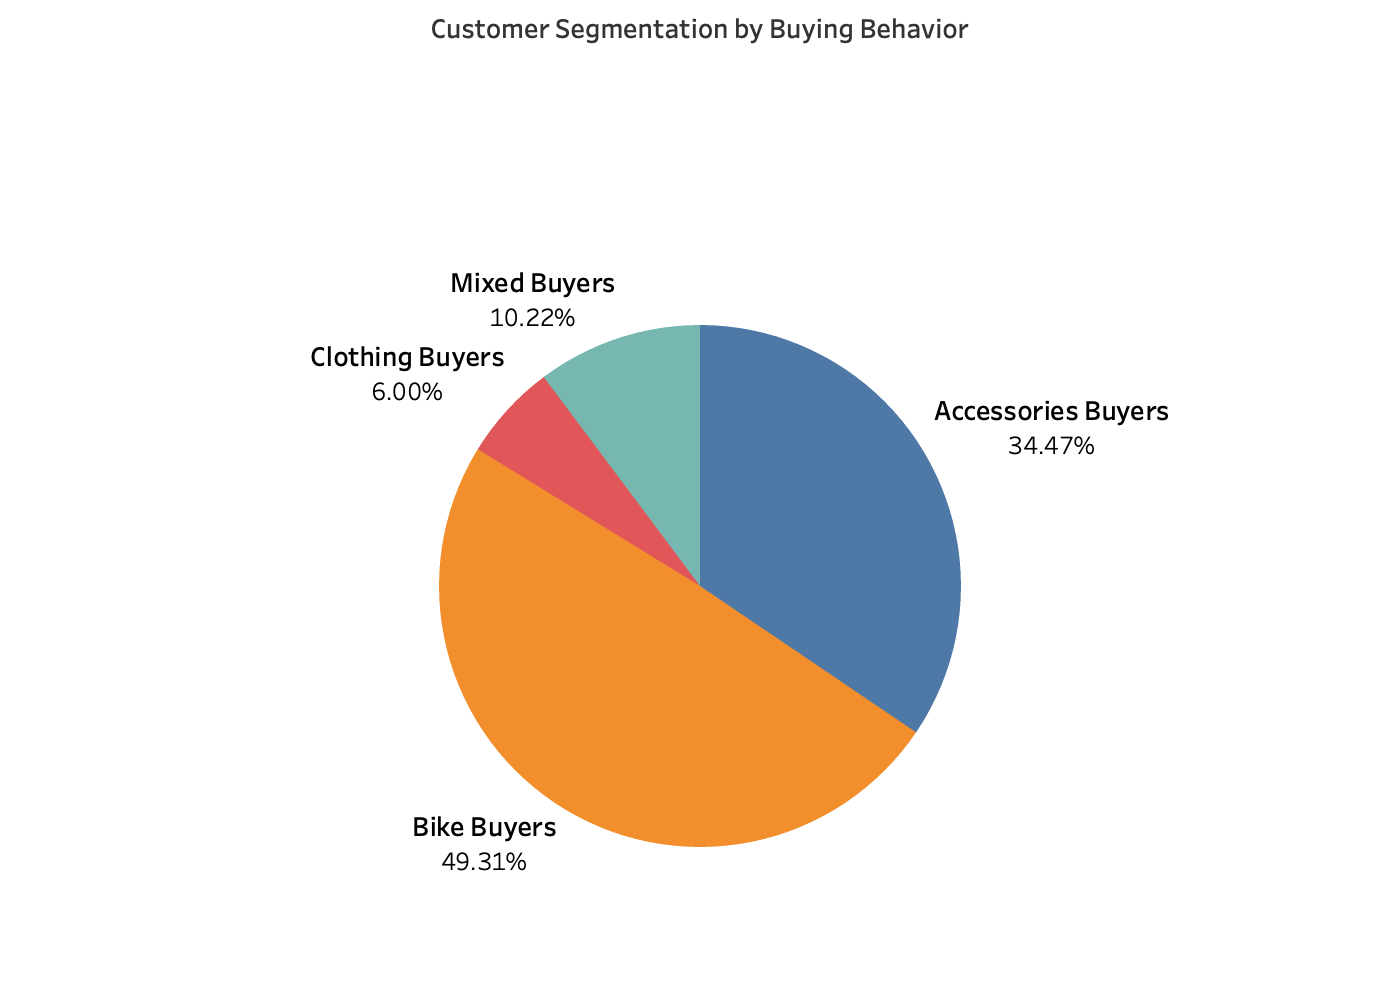

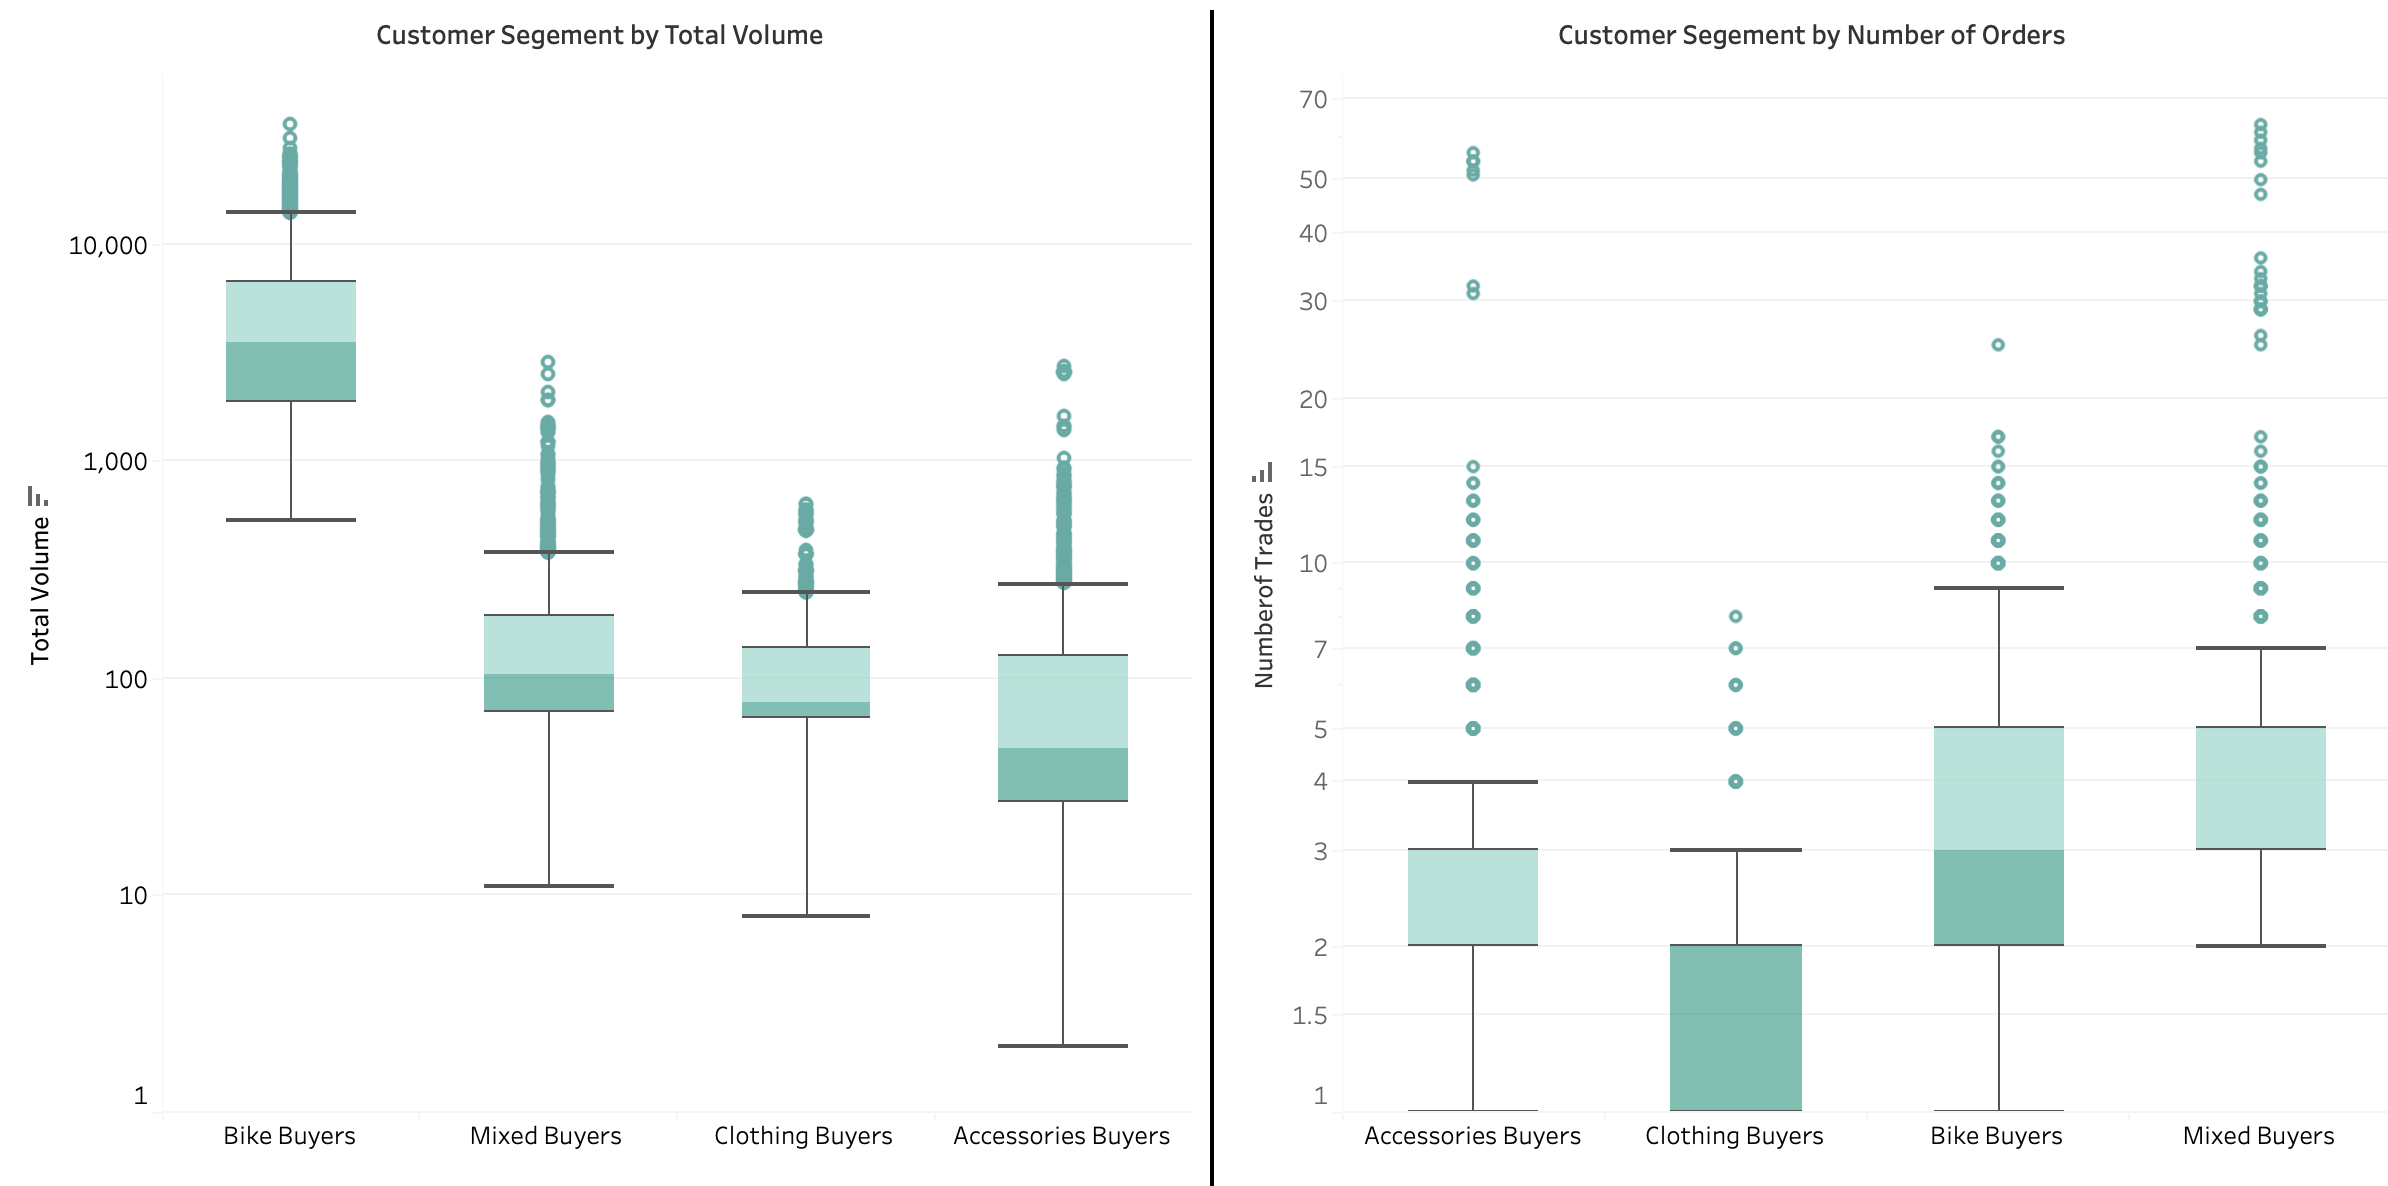

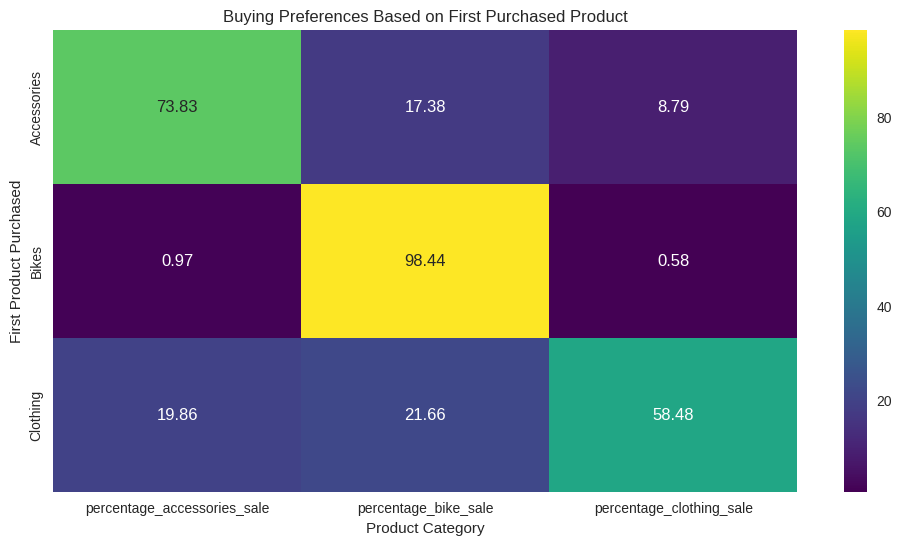

percentage_accessories_sale  percentage_bike_sale  \
first_product                                                      
Accessories                      73.831038             17.381889   
Bikes                             0.972530             98.444546   
Clothing                         19.862918             21.660354   

               percentage_clothing_sale  
first_product                            
Accessories                    8.787076  
Bikes                          0.582941  
Clothing                      58.476793

In [56]:
# Tính trung bình tỷ lệ mua sắm của từng nhóm first_product
first_product_trends = customer_df.groupby("first_product")[
    ["percentage_accessories_sale", "percentage_bike_sale", "percentage_clothing_sale"]
].mean()

# Vẽ heatmap để hiển thị xu hướng mua sắm theo first_product
plt.figure(figsize=(12, 6))
sns.heatmap(first_product_trends, annot=True, cmap="viridis", fmt=".2f")
plt.xlabel("Product Category")
plt.ylabel("First Product Purchased")
plt.title("Buying Preferences Based on First Purchased Product")
plt.show()

first_product_trends


In [57]:
# Filter customer_df có GD năm 2016
df_2016 = df[df['Year'] == 2016]
customers_2016 = df_2016['CustomerKey'].unique()
customer_df_2016 = customer_df[customer_df['CustomerKey'].isin(customers_2016)]
customer_df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17412 entries, 0 to 18480
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   CustomerKey                  17412 non-null  int64         
 1   FirstName                    17412 non-null  object        
 2   LastName                     17412 non-null  object        
 3   BirthDate                    17412 non-null  datetime64[ns]
 4   MaritalStatus                17412 non-null  object        
 5   Gender                       17412 non-null  object        
 6   YearlyIncome                 17412 non-null  int64         
 7   TotalChildren                17412 non-null  int64         
 8   Education                    17412 non-null  object        
 9   Occupation                   17412 non-null  object        
 10  HouseOwnerFlag               17412 non-null  object        
 11  NumberCarsOwned              17412 non-null  i

In [58]:
#K-mean
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer

num_features = [
    "YearlyIncome", "TotalChildren", "NumberCarsOwned", "TotalVolume", "NumberofTrades",
    "percentage_accessories_sale", "percentage_bike_sale", "percentage_clothing_sale"
]
cat_features = ["MaritalStatus", "Gender", "Education", "Occupation", "HouseOwnerFlag", "AgeGroup", "first_product"]

# Tiền xử lý dữ liệu
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Áp dụng tiền xử lý
customer_df_2016_processed = preprocessor.fit_transform(customer_df_2016)

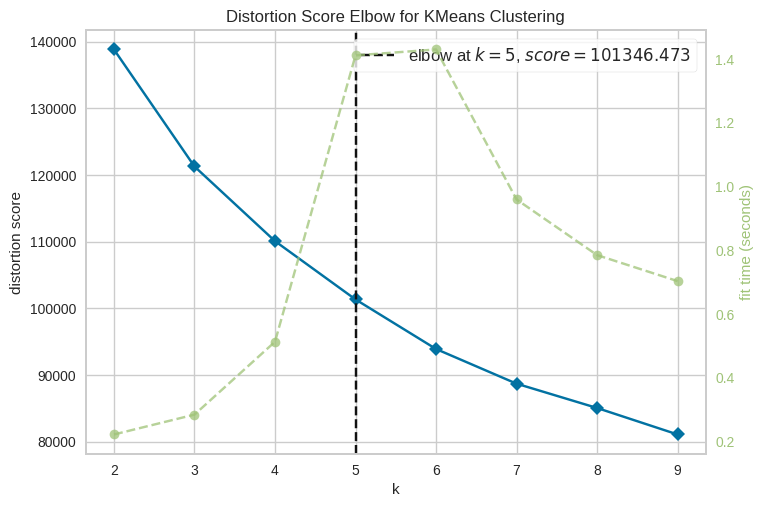

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
# Sử dụng KElbowVisualizer để tìm số cụm tối ưu
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(customer_df_2016_processed)
visualizer.show()

In [60]:
# Áp dụng K-means với số cụm tối ưu từ Elbow method
k_optimal = visualizer.elbow_value_
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
customer_df_2016["Cluster"] = kmeans.fit_predict(customer_df_2016_processed)

customer_df_2016["Cluster"].value_counts()

Cluster
1    5938
4    3694
0    2934
3    2716
2    2130
Name: count, dtype: int64

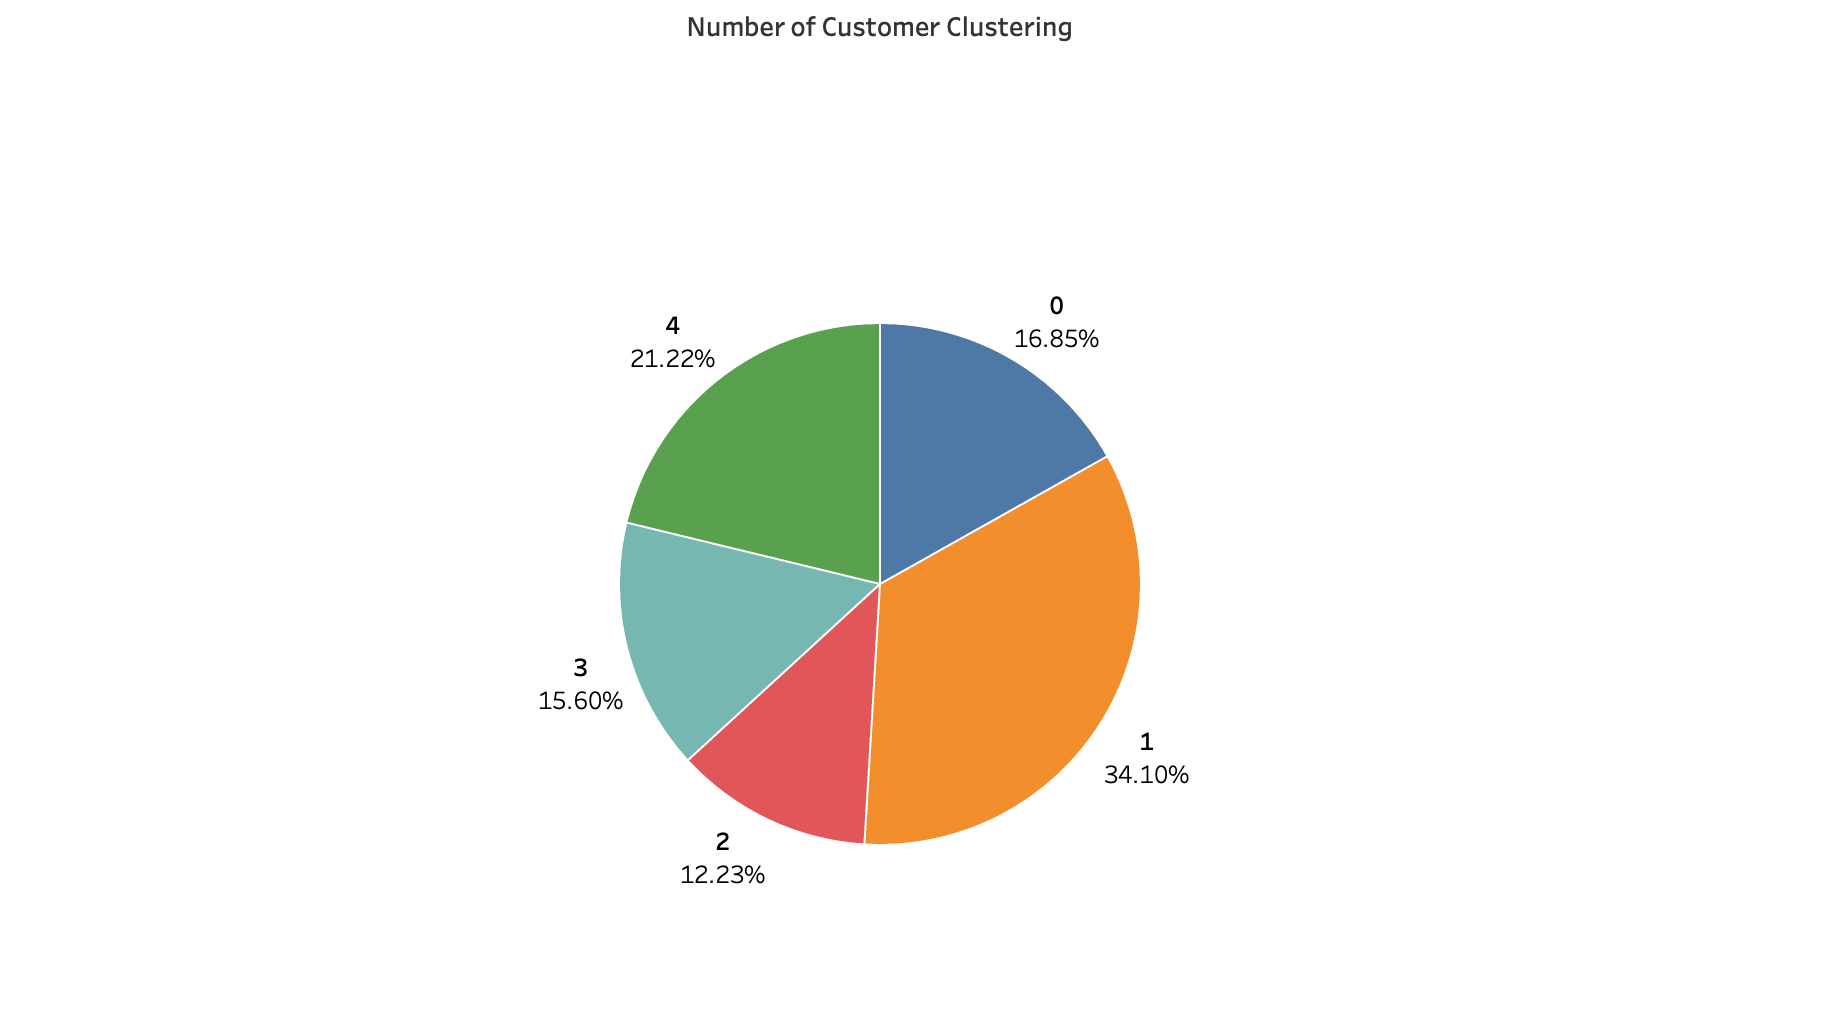

In [61]:
# Characteristics of clusters

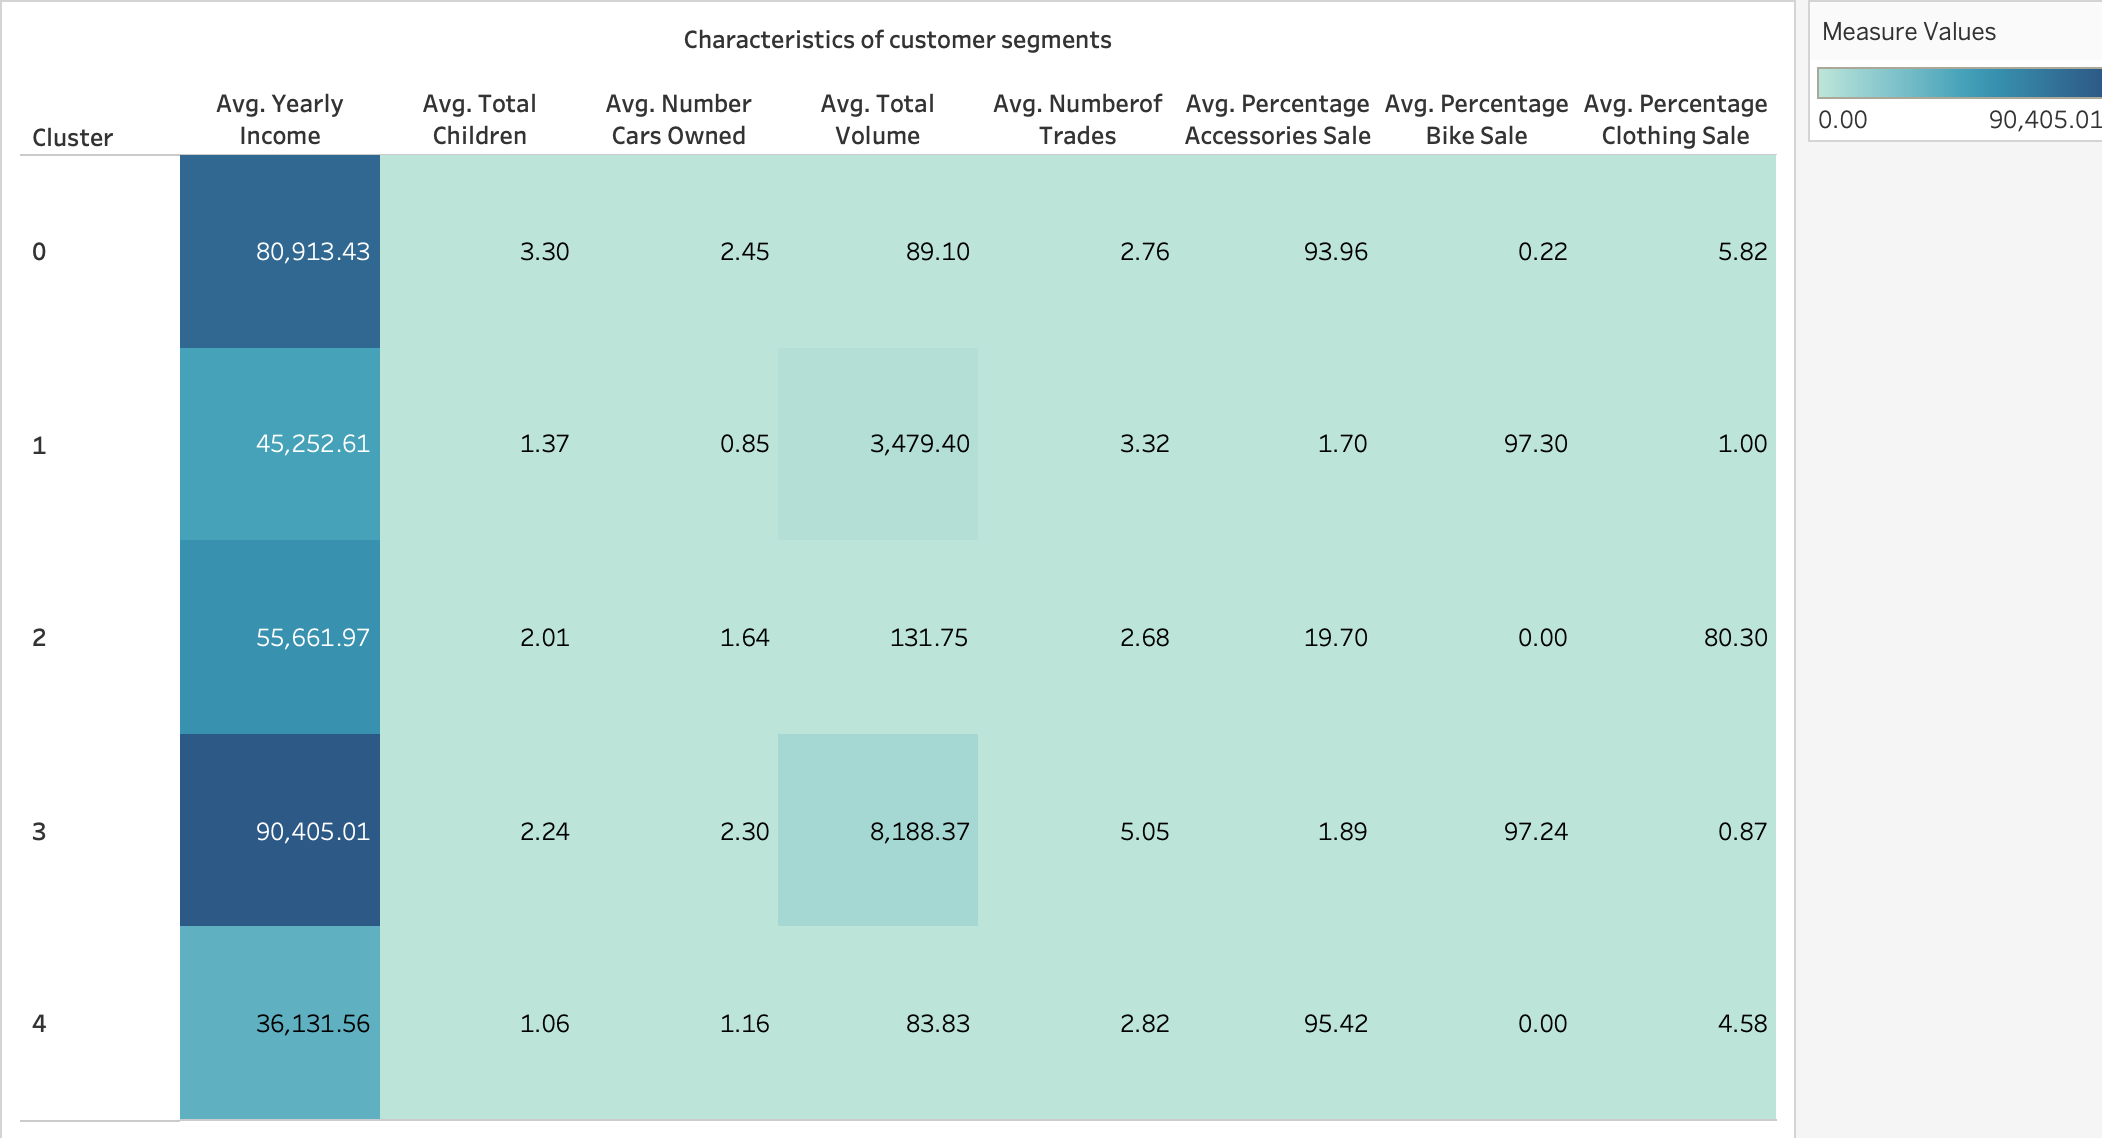

In [62]:
# Create a new column to name these cluster following:
# - 0: High-Spending Potential
# - 1: Loyal Bike Buyers
# - 2: Loyal Clothing Buyers
# - 3: VIP Customers
# - 4: Budget-Conscious Customers

cluster_mapping = {
    0: "High-Spending Potential",
    1: "Loyal Bike Buyers",
    2: "Potential Accessory & Clothing Buyers",
    3: "VIP Buyers",
    4: "Budget-Conscious Buyers"
}

customer_df_2016["Cluster_Name"] = customer_df_2016["Cluster"].map(cluster_mapping)


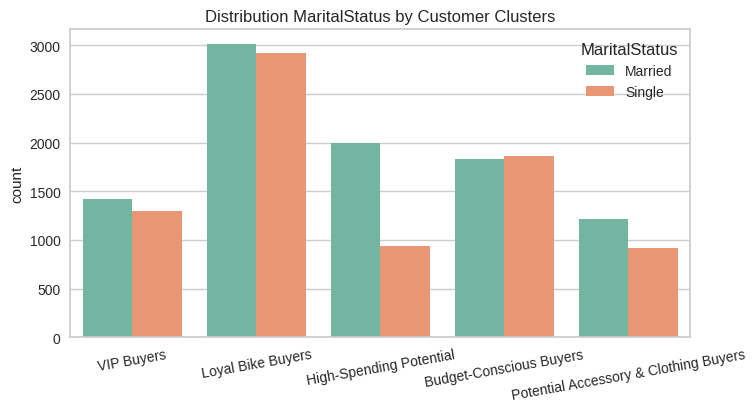

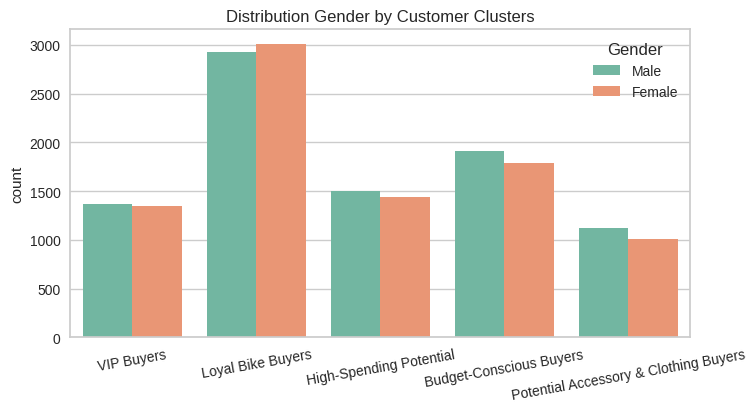

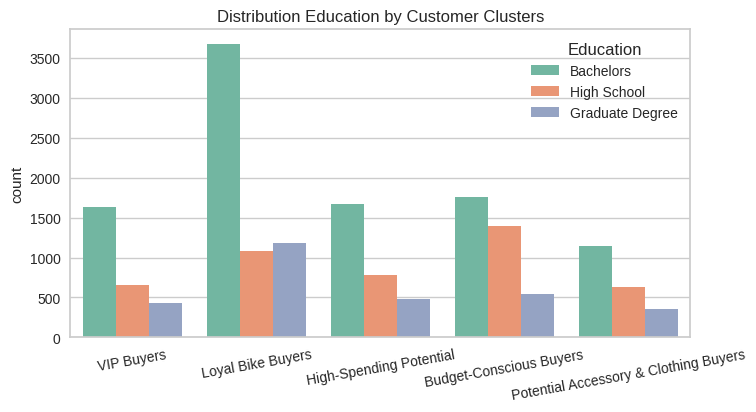

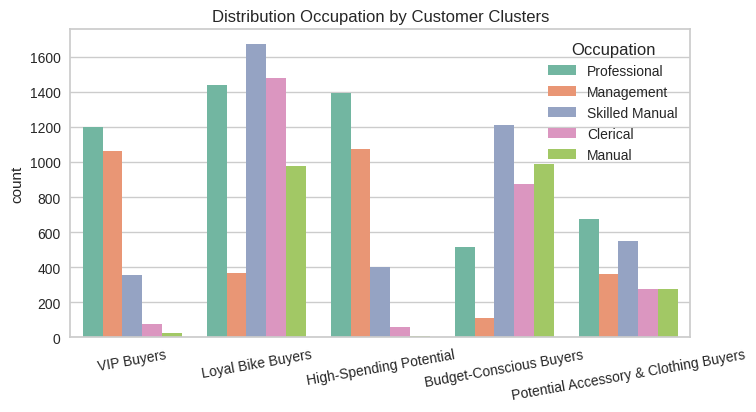

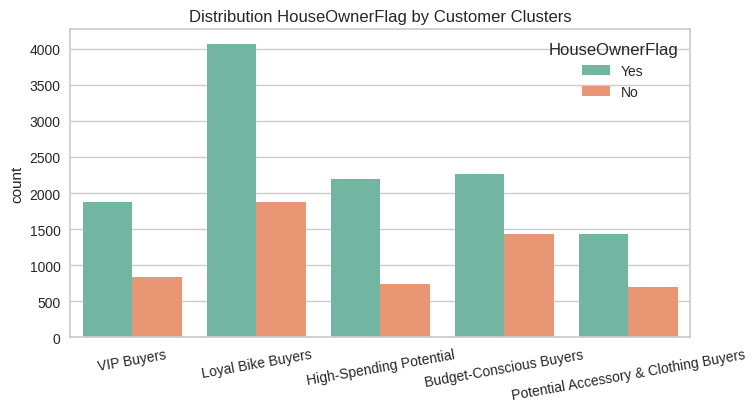

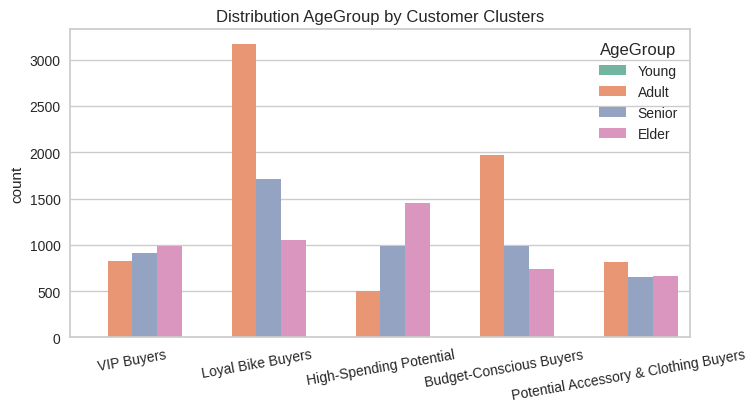

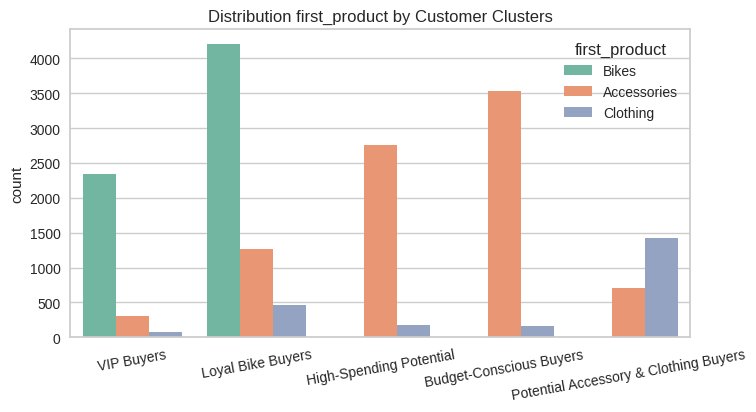

In [63]:
# Customer Cluster Distribution
for cat in cat_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x="Cluster_Name", hue=cat, data=customer_df_2016, palette='Set2')
    plt.title(f"Distribution {cat} by Customer Clusters")
    plt.xticks(rotation=10)
    plt.legend(title=cat)
    plt.xlabel('')
    plt.show()

## 2/ Performance Analysis

### 2.1/ Linear Regression

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  int64         
 2   CustomerKey        58182 non-null  object        
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  int64         
 9   TotalChildren      58182 non-null  int64         
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  int64         
 13  NumberCarsOwned    58182 non-null  int64         
 14  CarOwnerFla

In [77]:
df_merge = df.merge(customer_df[['first_product','first_sub_product_category','CustomerKey']], on = ['CustomerKey'], how = 'left')
features = [
    'Age', 'YearlyIncome', 'TotalChildren','HouseOwnerFlag','CarOwnerFlag',
    'Region', 'MaritalStatus',
    'Category', 'ProductLine', 'SubCategory','first_product','first_sub_product_category'
]
target = 'TotalSaleAmount'

# Preprocessing
num_cols = df_merge[features].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_merge[features].select_dtypes(include=['object', 'category']).columns.tolist()

X_num = df_merge[num_cols]
X_cat = pd.get_dummies(df_merge[cat_cols], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = df_merge[target]

bool_cols = X.select_dtypes(include='bool').columns
if len(bool_cols):
    X[bool_cols] = X[bool_cols].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [78]:
# === LINEAR REGRESSION WITH P‑VALUES ===
X_ols = sm.add_constant(X_train)
y_ols = y_train

ols = sm.OLS(y_ols, X_ols).fit()
print("=== OLS Summary ===")
print(ols.summary())

=== OLS Summary ===
                            OLS Regression Results                            
Dep. Variable:        TotalSaleAmount   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     854.2
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        07:22:01   Log-Likelihood:            -4.0088e+05
No. Observations:               46545   AIC:                         8.019e+05
Df Residuals:                   46494   BIC:                         8.023e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [79]:
X_ols_full = sm.add_constant(X_train)
ols_full = sm.OLS(y_train, X_ols_full).fit()

significant_features = ols_full.pvalues[ols_full.pvalues < 0.05].index.tolist()

X_significant = X_ols_full[significant_features]

ols_significant = sm.OLS(y_train, X_significant).fit()

print("=== OLS Summary with p-values < 0.05 ===")
print(ols_significant.summary())


=== OLS Summary with p-values < 0.05 ===
                                 OLS Regression Results                                
Dep. Variable:        TotalSaleAmount   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.559
Method:                 Least Squares   F-statistic:                              8416.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):                        0.00
Time:                        07:22:45   Log-Likelihood:                     -4.0095e+05
No. Observations:               46545   AIC:                                  8.019e+05
Df Residuals:                   46538   BIC:                                  8.020e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.

### 2.2/ Market Basket Analysis

In [71]:
# Masket Basket Analysis: in SubCategory

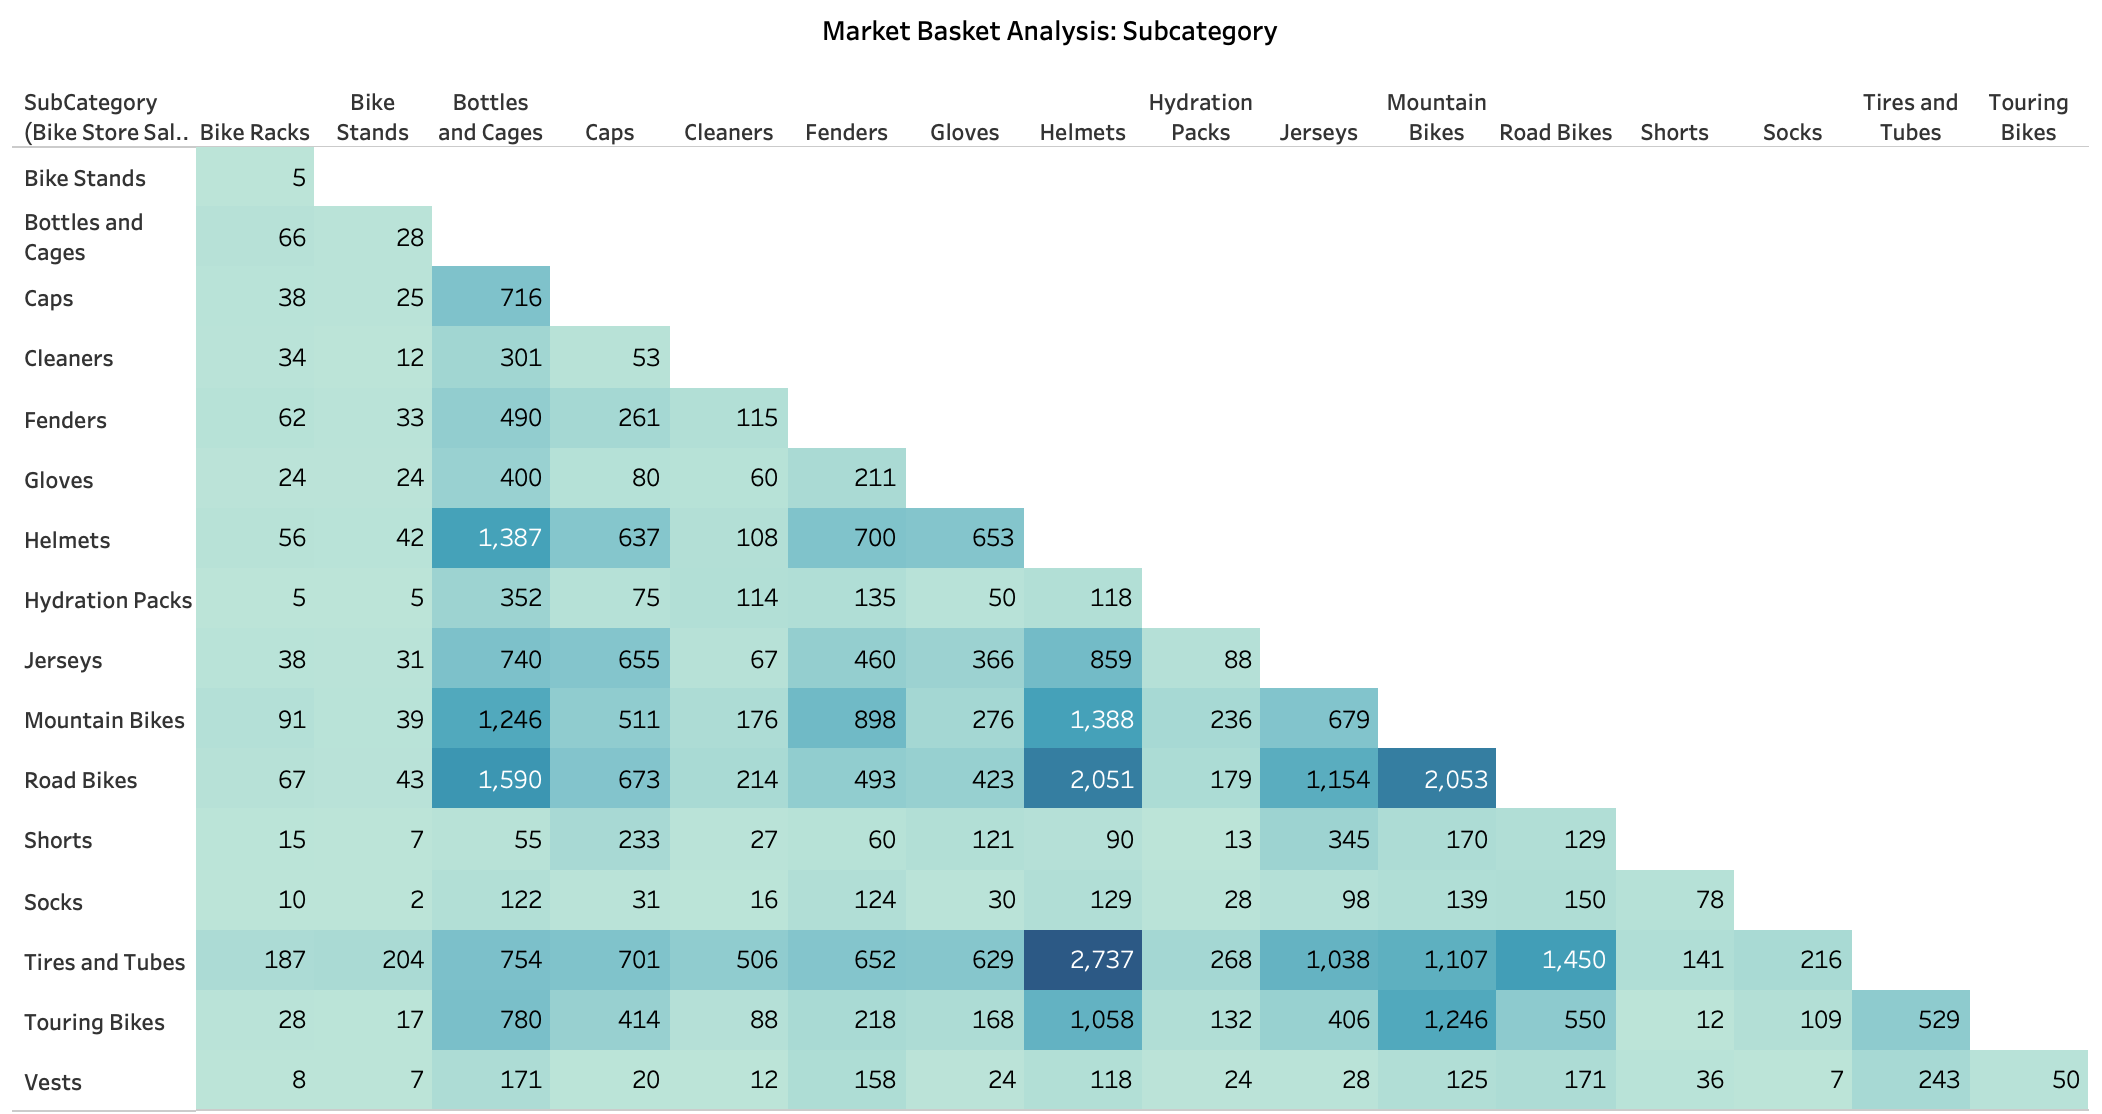

# Test customer segment

In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerKey      18484 non-null  int64         
 1   FirstName        18484 non-null  object        
 2   LastName         18484 non-null  object        
 3   BirthDate        18484 non-null  datetime64[ns]
 4   MaritalStatus    18484 non-null  object        
 5   Gender           18484 non-null  object        
 6   YearlyIncome     18484 non-null  int64         
 7   TotalChildren    18484 non-null  int64         
 8   Education        18484 non-null  object        
 9   Occupation       18484 non-null  object        
 10  HouseOwnerFlag   18484 non-null  object        
 11  NumberCarsOwned  18484 non-null  int64         
 12  FirstTrade       18484 non-null  datetime64[ns]
 13  LastTrade        18484 non-null  datetime64[ns]
 14  TotalVolume      18484 non-null  float

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  int64         
 2   CustomerKey        58182 non-null  object        
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  int64         
 9   TotalChildren      58182 non-null  int64         
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  int64         
 13  NumberCarsOwned    58182 non-null  int64         
 14  CarOwnerFla

In [ ]:
df.head(5)

Date  Year CustomerKey FirstName  LastName  BirthDate MaritalStatus  \
0 2016-01-16  2016     16218.0     Julia   Simmons 1953-10-04             M   
1 2016-01-31  2016     11224.0   Tiffany        Li 1951-09-06             S   
2 2016-02-03  2016     22282.0  Jonathan    Hughes 1964-01-27             S   
3 2016-02-07  2016     15257.0   Matthew  Anderson 1978-03-25             S   
4 2016-02-08  2016     29014.0      Ryan    Powell 1950-02-04             M   

  Gender  YearlyIncome  TotalChildren  ...            ProductName SubCategory  \
0      F         30000              1  ...  Sport-100 Helmet, Red     Helmets   
1      F         70000              2  ...  Sport-100 Helmet, Red     Helmets   
2      M         40000              0  ...  Sport-100 Helmet, Red     Helmets   
3      M         40000              0  ...  Sport-100 Helmet, Red     Helmets   
4      M         60000              2  ...  Sport-100 Helmet, Red     Helmets   

   StandardCost  ProductLine     Region        Country     Continents Age  \
0       13.0863        Sport  Northwest  United States  North America  63   
1       13.0863        Sport  Northwest  United States  North America  65   
2       13.0863        Sport  Northwest  United States  North America  52   
3       13.0863        Sport  Northwest  United States  North America  38   
4       13.0863        Sport  Northwest  United States  North America  66   

   AgeGroup   Profit  
0     Elder  18.2008  
1     Elder  18.2008  
2    Senior  40.2008  
3     Adult  18.2008  
4     Elder  18.2008  

[5 rows x 35 columns]

In [ ]:
first_product_df = df.sort_values(by="Date").groupby("CustomerKey").first().reset_index()
customer_df = customer_df.merge(first_product_df[["CustomerKey", "Category", "SubCategory"]], on="CustomerKey", how="left")
customer_df = customer_df.rename(columns={"Category": "first_product", "SubCategory": "first_sub_product_category"})


In [ ]:
first_product_df

CustomerKey       Date  Year  FirstName LastName  BirthDate  \
0          11000.0 2014-01-22  2014        Jon     Yang 1966-04-08   
1          11001.0 2014-01-18  2014     Eugene    Huang 1965-05-14   
2          11002.0 2014-01-10  2014      Ruben   Torres 1965-08-12   
3          11003.0 2014-01-01  2014    Christy      Zhu 1968-02-15   
4          11004.0 2014-01-26  2014  Elizabeth  Johnson 1968-08-08   
...            ...        ...   ...        ...      ...        ...   
17913      29479.0 2015-09-08  2015      Tommy     Tang 1958-07-04   
17914      29480.0 2016-07-18  2016       Nina     Raji 1960-11-10   
17915      29481.0 2014-08-13  2014       Ivan     Suri 1960-01-05   
17916      29482.0 2015-09-22  2015    Clayton    Zhang 1959-03-05   
17917      29483.0 2015-09-13  2015      Jésus  Navarro 1959-12-08   

      MaritalStatus Gender  YearlyIncome  TotalChildren  ...  \
0                 M      M         90000              2  ...   
1                 S      M         60000              3  ...   
2                 M      M         60000              3  ...   
3                 S      F         70000              0  ...   
4                 S      F         80000              5  ...   
...             ...    ...           ...            ...  ...   
17913             M      M         30000              1  ...   
17914             S      F         30000              3  ...   
17915             S      M         30000              3  ...   
17916             M      M         30000              3  ...   
17917             M      M         30000              0  ...   

                   ProductName     SubCategory  StandardCost  ProductLine  \
0      Mountain-100 Silver, 38  Mountain Bikes     1912.1544     Mountain   
1       Mountain-100 Black, 44  Mountain Bikes     1898.0944     Mountain   
2      Mountain-100 Silver, 44  Mountain Bikes     1912.1544     Mountain   
3      Mountain-100 Silver, 44  Mountain Bikes     1912.1544     Mountain   
4      Mountain-100 Silver, 42  Mountain Bikes     1912.1544     Mountain   
...                        ...             ...           ...          ...   
17913   Mountain-200 Black, 38  Mountain Bikes     1105.8100     Mountain   
17914  Touring-1000 Yellow, 50   Touring Bikes     1481.9379      Touring   
17915   Mountain-100 Black, 42  Mountain Bikes     1898.0944     Mountain   
17916   Mountain-200 Black, 38  Mountain Bikes     1105.8100     Mountain   
17917   Mountain-200 Black, 42  Mountain Bikes     1105.8100     Mountain   

               Region         Country Continents Age  AgeGroup     Profit  
0           Australia       Australia    Pacific  50     Adult  2703.0008  
1           Australia       Australia    Pacific  51    Senior  1206.0008  
2           Australia       Australia    Pacific  51    Senior  1215.0008  
3           Australia       Australia    Pacific  48     Adult  2703.0008  
4           Australia       Australia    Pacific  48     Adult  1215.0008  
...               ...             ...        ...  ..       ...        ...  
17913          France          France     Europe  58    Senior   780.0721  
17914  United Kingdom  United Kingdom     Europe  56    Senior  1614.2744  
17915         Germany         Germany     Europe  56    Senior  1206.0008  
17916          France          France     Europe  57    Senior   780.0721  
17917          France          France     Europe  57    Senior   780.0721  

[17918 rows x 35 columns]

In [ ]:
customer_df = customer_df.rename(columns={"Accessories": "percentage_accessories_sale", "Bikes": "percentage_bike_sale", "Clothing": "percentage_clothing_sale"})

In [ ]:
customer_df

CustomerKey  FirstName LastName  BirthDate MaritalStatus  Gender  \
0            11000        Jon     Yang 1966-04-08       Married    Male   
1            11001     Eugene    Huang 1965-05-14        Single    Male   
2            11002      Ruben   Torres 1965-08-12       Married    Male   
3            11003    Christy      Zhu 1968-02-15        Single  Female   
4            11004  Elizabeth  Johnson 1968-08-08        Single  Female   
...            ...        ...      ...        ...           ...     ...   
18479        29479      Tommy     Tang 1958-07-04       Married    Male   
18480        29480       Nina     Raji 1960-11-10        Single  Female   
18481        29481       Ivan     Suri 1960-01-05        Single    Male   
18482        29482    Clayton    Zhang 1959-03-05       Married    Male   
18483        29483      Jésus  Navarro 1959-12-08       Married    Male   

       YearlyIncome  TotalChildren        Education    Occupation  ...  \
0             90000              2        Bachelors  Professional  ...   
1             60000              3        Bachelors  Professional  ...   
2             60000              3        Bachelors  Professional  ...   
3             70000              0        Bachelors  Professional  ...   
4             80000              5        Bachelors  Professional  ...   
...             ...            ...              ...           ...  ...   
18479         30000              1  Graduate Degree      Clerical  ...   
18480         30000              3  Graduate Degree      Clerical  ...   
18481         30000              3  Graduate Degree      Clerical  ...   
18482         30000              3        Bachelors      Clerical  ...   
18483         30000              0        Bachelors      Clerical  ...   

       LastTrade  TotalVolume NumberofTrades AgeGroup  \
0     2016-05-04      11642.0            8.0    Adult   
1     2016-12-12       8793.0           11.0   Senior   
2     2016-02-27       8111.0            4.0   Senior   
3     2016-05-11      11532.0            9.0    Adult   
4     2016-05-02      10610.0            6.0    Adult   
...          ...          ...            ...      ...   
18479 2015-09-08       2049.0            1.0   Senior   
18480 2016-07-18       4880.0            5.0   Senior   
18481 2014-08-13       3374.0            1.0   Senior   
18482 2015-09-22       2049.0            1.0   Senior   
18483 2015-09-13       2049.0            1.0   Senior   

       percentage_accessories_sale  percentage_bike_sale  \
0                             0.75                 98.80   
1                             1.33                 97.26   
2                             0.42                 99.58   
3                             0.41                 99.52   
4                             1.17                 98.83   
...                            ...                   ...   
18479                         0.00                100.00   
18480                         1.95                 97.70   
18481                         0.00                100.00   
18482                         0.00                100.00   
18483                         0.00                100.00   

      percentage_clothing_sale          CarsOwned  first_product  \
0                         0.46      Not Owned Car          Bikes   
1                         1.41        Owned 1 Car          Bikes   
2                         0.00        Owned 1 Car          Bikes   
3                         0.07        Owned 1 Car          Bikes   
4                         0.00  Owned Over 2 Cars          Bikes   
...                        ...                ...            ...   
18479                     0.00      Not Owned Car          Bikes   
18480                     0.35      Not Owned Car          Bikes   
18481                     0.00      Not Owned Car          Bikes   
18482                     0.00      Not Owned Car          Bikes   
18483                     0.00      Not Owned Car          Bike

In [ ]:
old_customers = customer_df[customer_df['FirstTrade'] < '2016-01-01']
new_customers = customer_df[(customer_df['FirstTrade'] >= '2016-01-01')]

In [ ]:
new_customers['first_product'].value_counts()

first_product
Accessories    8574
Clothing       2289
Bikes          1627
Name: count, dtype: int64

In [ ]:
old_customers['first_product'].value_counts()

first_product
Bikes    5428
Name: count, dtype: int64

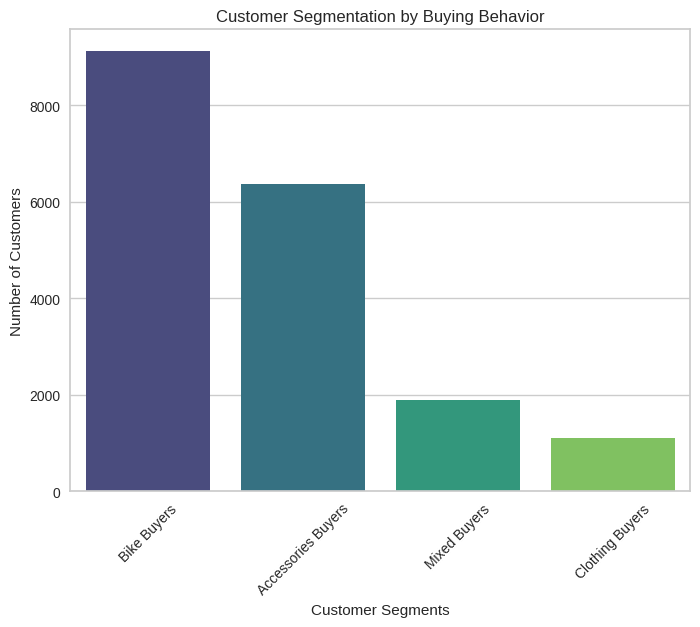

In [ ]:
# Tạo phân nhóm khách hàng dựa vào tỷ lệ mua sắm
def categorize_customer(row):
    if row["percentage_bike_sale"] > 80:
        return "Bike Buyers"
    elif row["percentage_accessories_sale"] > 80:
        return "Accessories Buyers"
    elif row["percentage_clothing_sale"] > 80:
        return "Clothing Buyers"
    else:
        return "Mixed Buyers"

# Áp dụng phân loại vào dataframe
customer_df["Customer_Segment"] = customer_df.apply(categorize_customer, axis=1)

# Đếm số lượng khách hàng theo nhóm
segment_counts = customer_df["Customer_Segment"].value_counts()

# Vẽ biểu đồ phân bố khách hàng theo phân khúc
plt.figure(figsize=(8, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Customer Segments")
plt.ylabel("Number of Customers")
plt.title("Customer Segmentation by Buying Behavior")
plt.show()



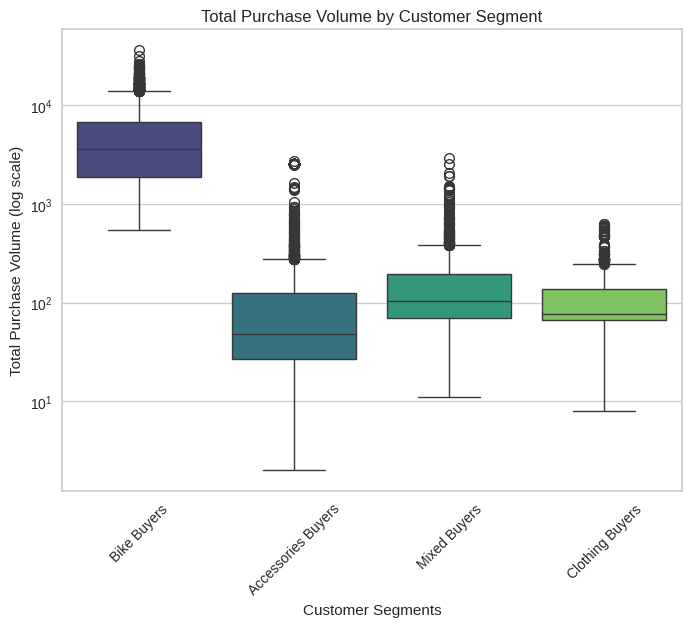

In [ ]:
# So sánh doanh thu trung bình giữa các phân khúc khách hàng
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_df, x="Customer_Segment", y="TotalVolume", palette="viridis")
plt.xticks(rotation=45)
plt.yscale("log")  # Dùng log scale để tránh ảnh hưởng của outliers
plt.xlabel("Customer Segments")
plt.ylabel("Total Purchase Volume (log scale)")
plt.title("Total Purchase Volume by Customer Segment")
plt.show()



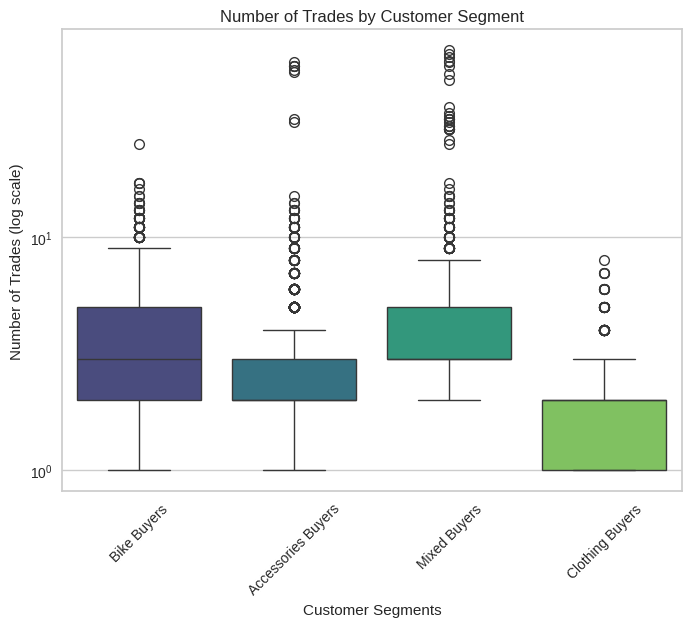

In [ ]:
# So sánh số lượng giao dịch trung bình giữa các phân khúc khách hàng
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_df, x="Customer_Segment", y="NumberofTrades", palette="viridis")
plt.xticks(rotation=45)
plt.yscale("log")
plt.xlabel("Customer Segments")
plt.ylabel("Number of Trades (log scale)")
plt.title("Number of Trades by Customer Segment")
plt.show()



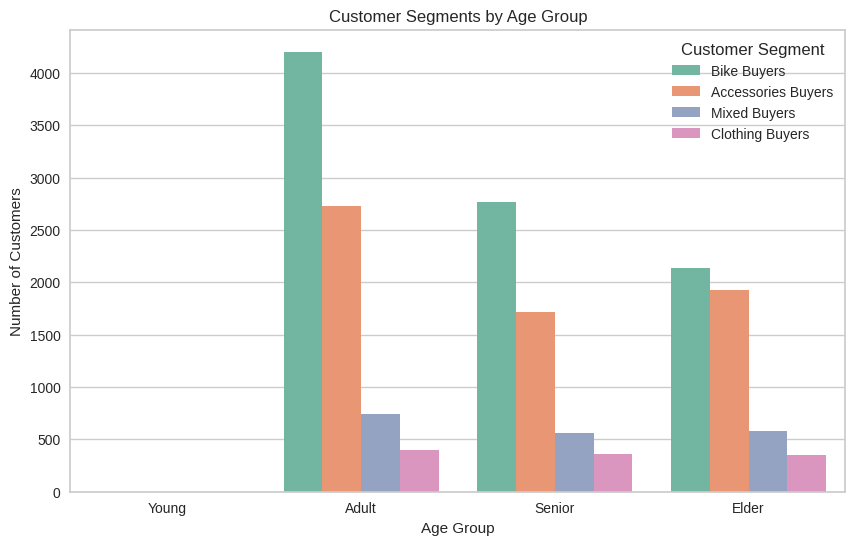

In [ ]:
# Biểu đồ phân phối độ tuổi theo phân khúc khách hàng
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_df, x="AgeGroup", hue="Customer_Segment", palette="Set2")
plt.xlabel("Age Group")
plt.ylabel("Number of Customers")
plt.title("Customer Segments by Age Group")
plt.legend(title="Customer Segment")
plt.show()


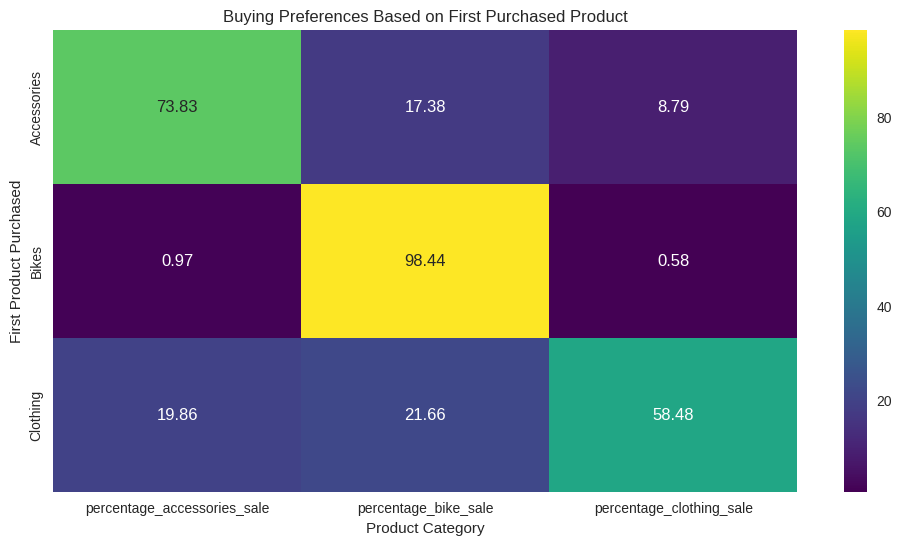

percentage_accessories_sale  percentage_bike_sale  \
first_product                                                      
Accessories                      73.831038             17.381889   
Bikes                             0.972530             98.444546   
Clothing                         19.862918             21.660354   

               percentage_clothing_sale  
first_product                            
Accessories                    8.787076  
Bikes                          0.582941  
Clothing                      58.476793

In [ ]:
# Tính trung bình tỷ lệ mua sắm của từng nhóm first_product
first_product_trends = customer_df.groupby("first_product")[
    ["percentage_accessories_sale", "percentage_bike_sale", "percentage_clothing_sale"]
].mean()

# Vẽ heatmap để hiển thị xu hướng mua sắm theo first_product
plt.figure(figsize=(12, 6))
sns.heatmap(first_product_trends, annot=True, cmap="viridis", fmt=".2f")
plt.xlabel("Product Category")
plt.ylabel("First Product Purchased")
plt.title("Buying Preferences Based on First Purchased Product")
plt.show()

first_product_trends


In [ ]:
# Filter customer_df có GD năm 2016
df_2016 = df[df['Year'] == 2016]
customers_2016 = df_2016['CustomerKey'].unique()
customer_df_2016 = customer_df[customer_df['CustomerKey'].isin(customers_2016)]
customer_df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17412 entries, 0 to 18480
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   CustomerKey                  17412 non-null  int64         
 1   FirstName                    17412 non-null  object        
 2   LastName                     17412 non-null  object        
 3   BirthDate                    17412 non-null  datetime64[ns]
 4   MaritalStatus                17412 non-null  object        
 5   Gender                       17412 non-null  object        
 6   YearlyIncome                 17412 non-null  int64         
 7   TotalChildren                17412 non-null  int64         
 8   Education                    17412 non-null  object        
 9   Occupation                   17412 non-null  object        
 10  HouseOwnerFlag               17412 non-null  object        
 11  NumberCarsOwned              17412 non-null  i

In [ ]:
#K-mean

num_features = [
    "YearlyIncome", "TotalChildren", "NumberCarsOwned", "TotalVolume", "NumberofTrades",
    "percentage_accessories_sale", "percentage_bike_sale", "percentage_clothing_sale"
]
cat_features = ["MaritalStatus", "Gender", "Education", "Occupation", "HouseOwnerFlag", "AgeGroup", "first_product"]

# Tiền xử lý dữ liệu
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Áp dụng tiền xử lý
customer_df_2016_processed = preprocessor.fit_transform(customer_df_2016)

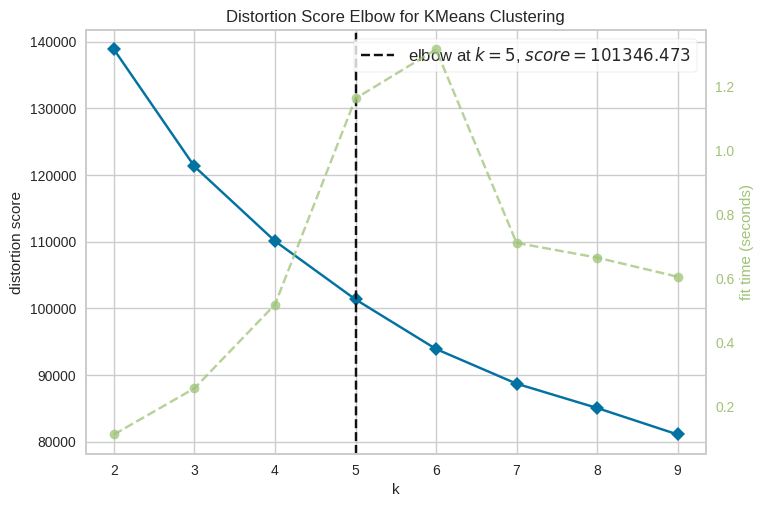

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Sử dụng KElbowVisualizer để tìm số cụm tối ưu
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(customer_df_2016_processed)
visualizer.show()

In [ ]:
# Áp dụng K-means với số cụm tối ưu từ Elbow method
k_optimal = visualizer.elbow_value_
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
customer_df_2016["Cluster"] = kmeans.fit_predict(customer_df_2016_processed)

customer_df_2016["Cluster"].value_counts()

Cluster
1    5938
4    3694
0    2934
3    2716
2    2130
Name: count, dtype: int64

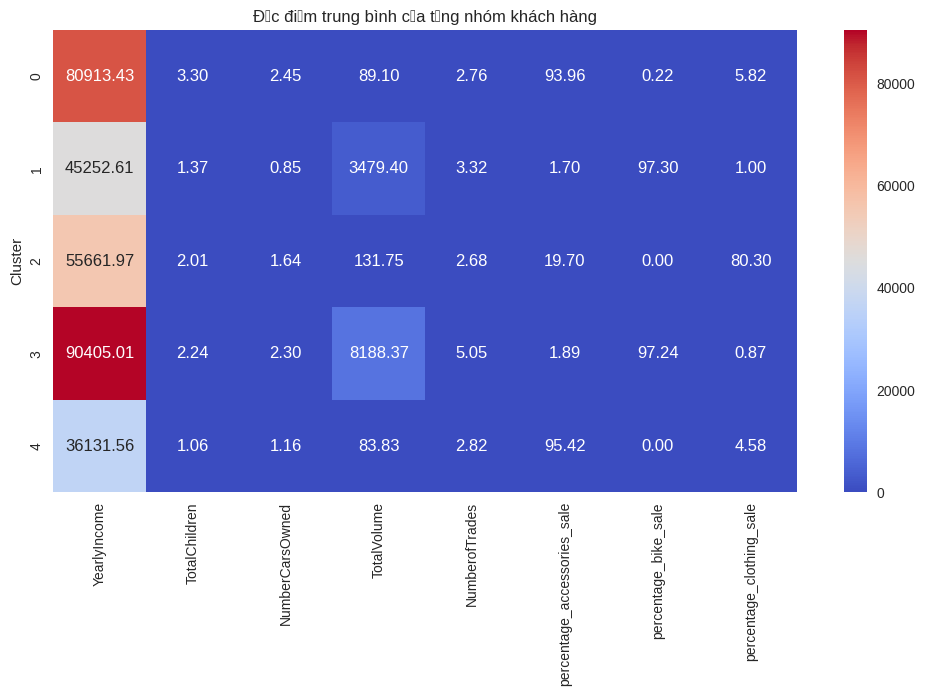

In [ ]:
# Phân tích đặc điểm từng cụm
grouped_clusters = customer_df_2016.groupby("Cluster")[num_features].mean()

# Vẽ biểu đồ để quan sát đặc điểm từng nhóm khách hàng
plt.figure(figsize=(12, 6))
sns.heatmap(grouped_clusters, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Đặc điểm trung bình của từng nhóm khách hàng")
plt.show()

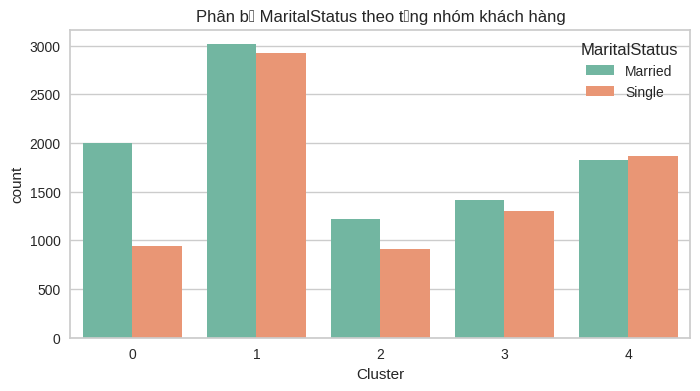

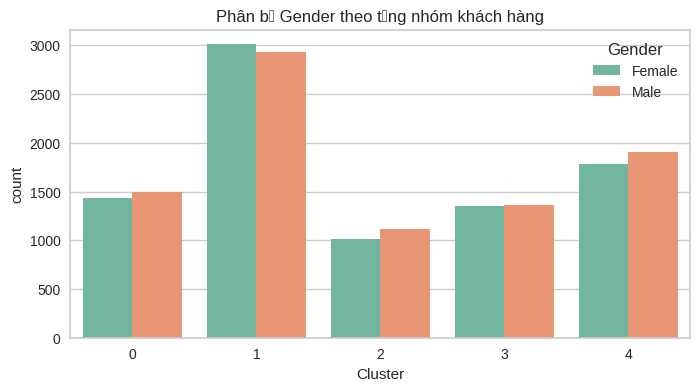

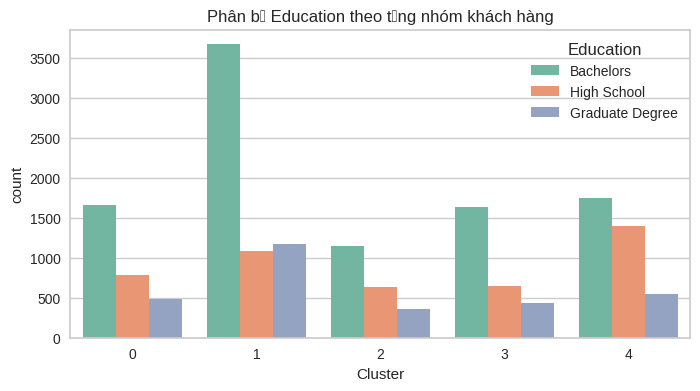

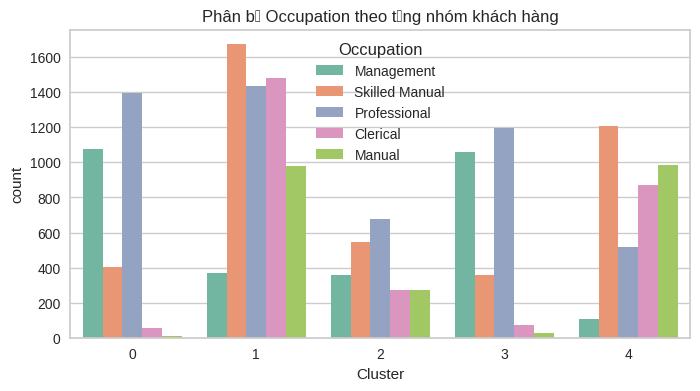

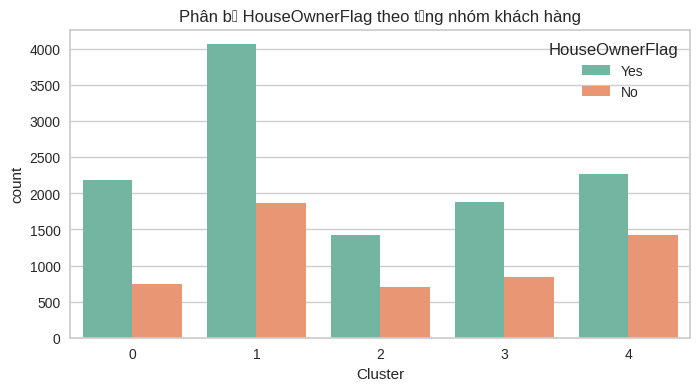

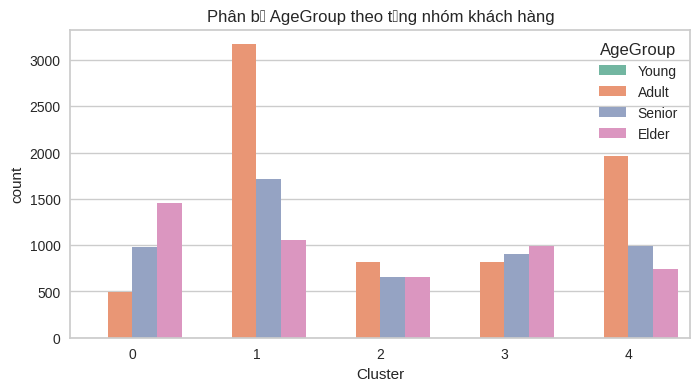

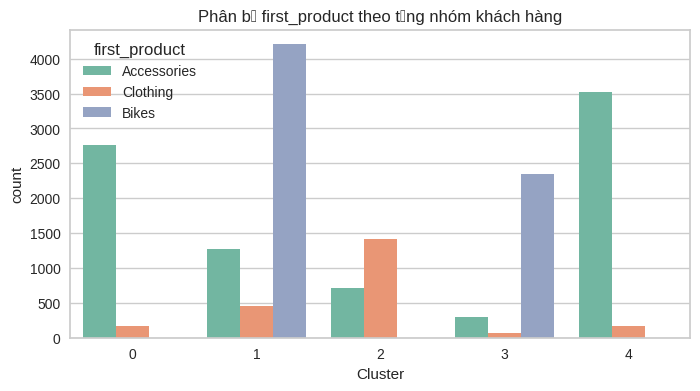

In [ ]:
# Phân tích đặc điểm từng cụm theo dữ liệu phân loại
for cat in cat_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x="Cluster", hue=cat, data=customer_df_2016, palette='Set2')
    plt.title(f"Phân bố {cat} theo từng nhóm khách hàng")
    plt.legend(title=cat)
    plt.show()

# Test sale prob prediction of each customer

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  int64         
 2   CustomerKey        58182 non-null  object        
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  int64         
 9   TotalChildren      58182 non-null  int64         
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  int64         
 13  NumberCarsOwned    58182 non-null  int64         
 14  CarOwnerFla

In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   CustomerKey                  18484 non-null  int64         
 1   FirstName                    18484 non-null  object        
 2   LastName                     18484 non-null  object        
 3   BirthDate                    18484 non-null  datetime64[ns]
 4   MaritalStatus                18484 non-null  object        
 5   Gender                       18484 non-null  object        
 6   YearlyIncome                 18484 non-null  int64         
 7   TotalChildren                18484 non-null  int64         
 8   Education                    18484 non-null  object        
 9   Occupation                   18484 non-null  object        
 10  HouseOwnerFlag               18484 non-null  object        
 11  NumberCarsOwned              18484 non-nu

In [ ]:
customer_df['Education'].unique()

array(['Bachelors', 'High School', 'Graduate Degree'], dtype=object)

In [ ]:
# Clean data
df['OrderDate'] = (df['Date'])

# Compute first order date for each customer
first_orders = df.groupby('CustomerKey').OrderDate.min().reset_index().rename(columns={'OrderDate': 'FirstOrderDate'})
df = pd.merge(sales, first_orders, on='CustomerKey', how='left')

# Identify the second order date
sales_after_first = df[df['OrderDate'] > df['FirstOrderDate']]
second_orders = sales_after_first.groupby('CustomerKey')['OrderDate'].min().reset_index().rename(columns={'OrderDate': 'SecondOrderDate'})
customer_orders = pd.merge(first_orders, second_orders, on='CustomerKey', how='left')
customer_orders['DaysToSecondOrder'] = (customer_orders['SecondOrderDate'] - customer_orders['FirstOrderDate']).dt.days

# Define a time window (e.g., 90 days) for classification
time_window = 90
customer_orders['reordered_within_window'] = customer_orders['DaysToSecondOrder'].apply(
    lambda x: 1 if pd.notnull(x) and x <= time_window else 0)

# --- Feature Engineering ---

# Merge data
data = pd.merge(customer_orders, customer_df, on='CustomerKey', how='left')
categorical_vars = ['MaritalStatus', 'Gender', 'Education', 'Occupation', 'HouseOwnerFlag', 'AgeGroup', 'first_product']
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

# --- Step 1: Classification Model ---
feature_columns = ['YearlyIncome', 'TotalChildren', 'NumberCarsOwned', 'TotalVolume', 'NumberofTrades',
                   'percentage_accessories_sale', 'percentage_bike_sale', 'percentage_clothing_sale'] + \
                   [col for col in data.columns if col.startswith(tuple(categorical_vars))]

X = data[feature_columns]
y = data['reordered_within_window']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate classifier
y_pred_proba = clf.predict_proba(X_test)[:, 1]
print("AUC score:", roc_auc_score(y_test, y_pred_proba))

# --- Step 2: Regression Model ---
# Use only customers who placed a second order (observed gap)
observed = data[data['DaysToSecondOrder'].notnull()]
X_reg = observed[feature_columns]
y_reg = observed['DaysToSecondOrder']

# Split into train and test sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train a linear regression model
reg = LinearRegression()
reg.fit(X_reg_train, y_reg_train)

# Predict and evaluate
y_pred = reg.predict(X_reg_test)
print("Mean Absolute Error on Days Prediction:", mean_absolute_error(y_reg_test, y_pred))


AUC score: 0.90963218875319
Mean Absolute Error on Days Prediction: 149.14925150626152


In [ ]:
# ------------------
# Example: New Customer Input
# ------------------
# Create a DataFrame for one customer.
# Note: The column names should match exactly the ones used to train the models.
sample_input = pd.DataFrame({
    'YearlyIncome': [75000],
    'TotalChildren': [2],
    'NumberCarsOwned': [1],
    'TotalVolume': [3000],
    'NumberofTrades': [5],
    'percentage_accessories_sale': [0.20],
    'percentage_bike_sale': [0.50],
    'percentage_clothing_sale': [0.30],

    # One-hot encoded categorical variables (example columns):
    'MaritalStatus_Single': [1],
    'Gender_Male': [1],
    'Education_High School': [1],
    'Occupation_Management': [0],
    'AgeGroup_Adult': [1],
    'HouseOwnerFlag_Yes': [1],
    'first_product_Bikes': [1]
    # Add additional columns as used during training if needed.
})

# ------------------
# Step 1: Classification - Propensity to Buy
# ------------------
# Use the classifier to predict the probability that this customer will make a second order within the time window.
propensity_probability = clf.predict_proba(sample_input)[:, 1][0]
print("Predicted Propensity to Buy (Probability):", round(propensity_probability, 3))

# ------------------
# Step 2: Regression - Days Until Next Order
# ------------------
# Use the regressor to predict the number of days until the second order.
# Note: The regression model was trained only on customers who ordered a second time.
predicted_days = reg.predict(sample_input)[0]
print("Predicted Days Until Next Order:", round(predicted_days, 1))


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- AgeGroup_Elder
- AgeGroup_Senior
- Education_Graduate Degree
- Occupation_Manual
- Occupation_Professional
- ...


In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   CustomerKey                  18484 non-null  int64         
 1   FirstName                    18484 non-null  object        
 2   LastName                     18484 non-null  object        
 3   BirthDate                    18484 non-null  datetime64[ns]
 4   MaritalStatus                18484 non-null  object        
 5   Gender                       18484 non-null  object        
 6   YearlyIncome                 18484 non-null  int64         
 7   TotalChildren                18484 non-null  int64         
 8   Education                    18484 non-null  object        
 9   Occupation                   18484 non-null  object        
 10  HouseOwnerFlag               18484 non-null  object        
 11  NumberCarsOwned              18484 non-nu

# Test sale prediction

In [72]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   CustomerKey                  18484 non-null  int64         
 1   FirstName                    18484 non-null  object        
 2   LastName                     18484 non-null  object        
 3   BirthDate                    18484 non-null  datetime64[ns]
 4   MaritalStatus                18484 non-null  object        
 5   Gender                       18484 non-null  object        
 6   YearlyIncome                 18484 non-null  int64         
 7   TotalChildren                18484 non-null  int64         
 8   Education                    18484 non-null  object        
 9   Occupation                   18484 non-null  object        
 10  HouseOwnerFlag               18484 non-null  object        
 11  NumberCarsOwned              18484 non-nu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58182 entries, 0 to 58188
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               58182 non-null  datetime64[ns]
 1   Year               58182 non-null  int64         
 2   CustomerKey        58182 non-null  object        
 3   FirstName          58182 non-null  object        
 4   LastName           58182 non-null  object        
 5   BirthDate          58182 non-null  datetime64[ns]
 6   MaritalStatus      58182 non-null  object        
 7   Gender             58182 non-null  object        
 8   YearlyIncome       58182 non-null  int64         
 9   TotalChildren      58182 non-null  int64         
 10  Education          58182 non-null  object        
 11  Occupation         58182 non-null  object        
 12  HouseOwnerFlag     58182 non-null  int64         
 13  NumberCarsOwned    58182 non-null  int64         
 14  CarOwnerFla

In [73]:
df_merge = df.merge(customer_df[['first_product','first_sub_product_category','CustomerKey']], on = ['CustomerKey'], how = 'left')
features = [
    'Age', 'YearlyIncome', 'TotalChildren','HouseOwnerFlag','CarOwnerFlag',
    'Region', 'MaritalStatus',
    'Category', 'ProductLine', 'SubCategory','first_product','first_sub_product_category'
]
target = 'TotalSaleAmount'

# Preprocessing
num_cols = df_merge[features].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_merge[features].select_dtypes(include=['object', 'category']).columns.tolist()

X_num = df_merge[num_cols]
X_cat = pd.get_dummies(df_merge[cat_cols], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = df_merge[target]

bool_cols = X.select_dtypes(include='bool').columns
if len(bool_cols):
    X[bool_cols] = X[bool_cols].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [74]:
# === LINEAR REGRESSION WITH P‑VALUES ===
X_ols = sm.add_constant(X_train)
y_ols = y_train

ols = sm.OLS(y_ols, X_ols).fit()
print("=== OLS Summary ===")
print(ols.summary())

=== OLS Summary ===
                            OLS Regression Results                            
Dep. Variable:        TotalSaleAmount   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     854.2
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        07:16:26   Log-Likelihood:            -4.0088e+05
No. Observations:               46545   AIC:                         8.019e+05
Df Residuals:                   46494   BIC:                         8.023e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [76]:
import statsmodels.api as sm

# Step 1: Fit initial OLS model with all features
X_ols_full = sm.add_constant(X_train)
ols_full = sm.OLS(y_train, X_ols_full).fit()

# Step 2: Get features with p-value < 0.05
significant_features = ols_full.pvalues[ols_full.pvalues < 0.05].index.tolist()

# Step 3: Make sure to include 'const' if it's among significant features
X_significant = X_ols_full[significant_features]

# Step 4: Fit a new OLS model with only significant features
ols_significant = sm.OLS(y_train, X_significant).fit()

# Step 5: Print the summary of the new model
print("=== OLS Summary with p-values < 0.05 ===")
print(ols_significant.summary())


=== OLS Summary with p-values < 0.05 ===
                                 OLS Regression Results                                
Dep. Variable:        TotalSaleAmount   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.559
Method:                 Least Squares   F-statistic:                              8416.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):                        0.00
Time:                        07:19:46   Log-Likelihood:                     -4.0095e+05
No. Observations:               46545   AIC:                                  8.019e+05
Df Residuals:                   46538   BIC:                                  8.020e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.

In [ ]:
# === RANDOM FOREST & XGBOOST ===
rf  = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
xgb = XGBRegressor(n_estimators=100, max_depth=6,
                   learning_rate=0.1, random_state=42, verbosity=0)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

results = {}
for name, model in [('RandomForest', rf), ('XGBoost', xgb)]:
    preds = model.predict(X_test)
    results[name] = {
        'MSE': mean_squared_error(y_test, preds),
        'MAE':  mean_absolute_error(y_test, preds),
        'R2':   r2_score(y_test, preds)
    }

print("\n=== Tree‑Based Model Performance ===")
print(pd.DataFrame(results).T)


=== Tree‑Based Model Performance ===
                       MSE         MAE        R2
RandomForest  1.817394e+06  480.090907  0.480623
XGBoost       1.816862e+06  480.169128  0.480775


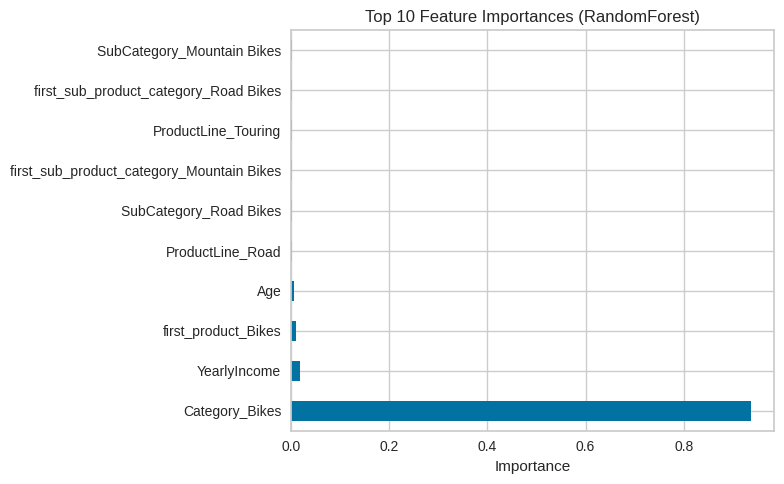

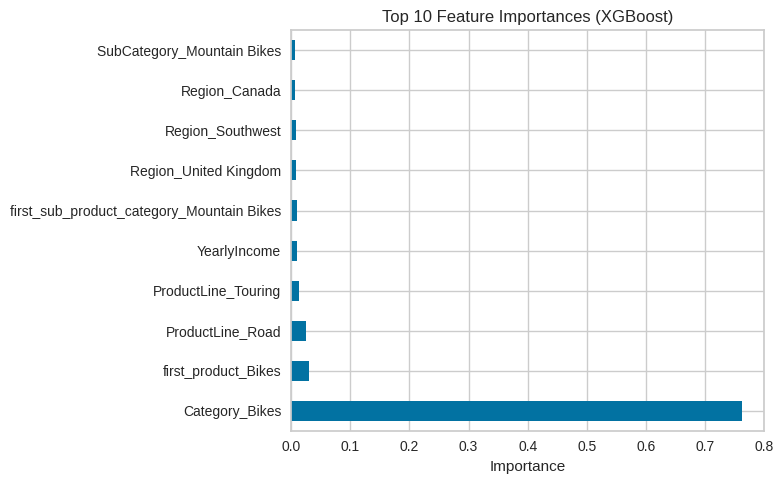

In [ ]:
for model, label in [(rf, "RandomForest"), (xgb, "XGBoost")]:
    imp = pd.Series(model.feature_importances_, index=X_train.columns)
    top10 = imp.nlargest(10)
    plt.figure(figsize=(8,5))
    top10.plot(kind='barh')
    plt.title(f"Top 10 Feature Importances ({label})")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()